# Imports and dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import keras
from keras import Sequential

from time import sleep
from operator import itemgetter
import os
import numpy as np
import matplotlib.pyplot as plt
import time 
import timeit
import progressbar
import pandas as pd

from skimage.transform import resize 
from sklearn.utils import shuffle
from sklearn.cluster import AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage import io

from scipy.optimize import minimize_scalar
from scipy.io import loadmat
from scipy import stats

# Models

In [2]:
# Modelo convolucional simple
#define the convnet
def convnet_simple(num_classes,input_shape):
  
  model = Sequential()
  # CONV => RELU => CONV => RELU => POOL => DROPOUT
  model.add(Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=input_shape))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # CONV => RELU => CONV => RELU => POOL => DROPOUT
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # FLATTERN => DENSE => RELU => DROPOUT
  model.add(Flatten())
  model.add(Dense(512, activation ='relu'))
  model.add(Dropout(0.5))
  # a softmax classifier
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  return model

In [3]:

from keras.activations import relu
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers


class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(64)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x



In [4]:
import keras.backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.utils import get_file


import keras
from distutils.version import StrictVersion

if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras.applications.imagenet_utils import obtain_input_shape


def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def usual_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

# default parameters for convolution and batchnorm layers of ResNet models
# parameters are obtained from MXNet converted model

def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params

def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params


def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    input_shape = obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    
    inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model


weights_collection = [
    # ResNet34
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },

    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    },
]


def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, 'resnet34', dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))


def ResNet34_V2(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    #model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model

from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0      
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

# Functions


## GradCAM

In [5]:
def grad_cam_plus(img, model,  layer_name, label_name=None, category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor) # De aqui se obtiene (8,8,640)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)


    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    
    # Aqui se computa el valor alpha, que yo he llamado pixel importance weight 
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10) # Esto no se que es lo que hace
       
    # Ahora junta numerador y denominador, pero luego hace una normalizacion que no entiendo por que la hace
    alphas = alpha_num/alpha_denom  # (8,8,640)
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas = tf.math.divide_no_nan(alphas,alpha_normalization_constant) # Esta normalizacion tambien la hacen en el codigo original del paper, es para evitar que los feature maps que son 0 no den el fallo de que se dividan por 0 a si mismos.
    #alphas /= alpha_normalization_constant 
    weights = np.maximum(conv_first_grad[0], 0.0) # ReLU a los gradientes. Demostrado empiricamente que funciona mejor

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1)) # Los Neuron Importance Weights de GradCAM
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2) # Computa el mapa haciendo el sumatorio de cada mapa por su w

    # Se queda solo con los valores positivos y para la visualizacion normaliza
    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    #if max_heat == 0: # Para evitar NaN, asi que uso la funcion de tf especifica
    #    max_heat = 1e-10
    heatmap = tf.math.divide_no_nan(heatmap, max_heat) 

    return heatmap


def grad_cam(img,model, 
             layer_name="block5_conv3", label_name=None,
             category_id=None):
    """Get a heatmap by Grad-CAM.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    #print(tf.math.reduce_max(grads,axis=(0,1,2)))
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

## Visualizations

In [6]:
# Funcion que hace plot del entrenamiento, donde se ve la acc vs loss
def plot_historia(history):
  
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[         'loss' ]
  val_loss = history.history[     'val_loss' ]

  epochs    = range(1,len(acc)+1,1) # obtener número de epochs del eje X

  plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
  plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
  plt.title ('Training and Validation Accuracy')
  plt.ylabel('acc')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()


  plt.plot  ( epochs,     loss, 'r--', label='Training loss'  )
  plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.title ('Training and Validation Loss'   )
  plt.ylabel('loss')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()


# Funcion que hace plot de los heatmaps creados
def plot_heatmaps(rows, cols, inicio, layer_names, preds, test_images, test_labels,top_pred_index=None, numero=None, img_resize=True):
  """
  En cada columna va una instacia de test_images
  En cada fila se representa lo siguiente:
    1) La imagen del numero
    2) El GradCAM heatmap
    3) El Saliency map
    4) GrandCAM + Numero superpuestos
    5) Saliency Map + Numero superpuestos

  Si se proporciona un numero, solo hace el plot de dicho numero
  """
  if numero != None:
    indices = buscar_num(numero,cols,test_labels,inicio) # Los indices del número que has definido que hay que buscar
  else:
    indices = [r for r in range(inicio,inicio+cols)] # En caso de no definir un numero simplemente hace plot desde la pos inicio
  for j in range(cols):
    grad_cam_hm, saliency = make_gradcam_heatmap_V2(np.expand_dims(test_images[indices[j]],axis=0),model, 'conv2d_1', layer_names)
    img = test_images[indices[j],:,:,0]
    ax[0,j].imshow(img, cmap='binary')
    set_axis_props(0,j,np.argmax(preds[indices[j]]))
    if img_resize == True:
      ax[1,j].imshow(resize(grad_cam_hm, (28,28)))
    else:
      ax[1,j].imshow(grad_cam_hm)
    set_axis_props(1,j)
    if img_resize == True:
      ax[2,j].imshow(resize(saliency, (28,28)))
    else:
      ax[2,j].imshow(saliency)
    set_axis_props(2,j)
    subplt_hotmap(3,j,img,grad_cam_hm)
    set_axis_props(3,j)
    subplt_hotmap(4,j,img,saliency)
    set_axis_props(4,j)
  fig.show()


# Funcion para definir las propiedades de un subplot
def set_axis_props(i,j, title=None):
  ax[i,j].set_xticks([])
  ax[i,j].set_yticks([])
  if title != None:
    ax[i,j].set_title(title, fontsize=30)


# Hace plot del heatmap en el axes le pases
def plot_heatmap(axes,i,j,heatmap,resize_img=False,title=None,superimposed_img=False,imagen=None):
  if imagen.ndim !=2:
    imagen = imagen.squeeze()
  if superimposed_img == True:
    axes[i,j].imshow(imagen,vmin=0,vmax=1)
    axes[i,j].imshow(resize(heatmap,(28,28)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
  elif resize_img == False:
    axes[i,j].imshow(heatmap,vmin=0,vmax=1)
  else:
    axes[i,j].imshow(resize(heatmap,(28,28)),vmin=0,vmax=1)
  axes[i,j].set_xticks([])
  axes[i,j].set_yticks([])
  if title != None:
    axes[i,j].set_title(title, fontsize=30)
  return axes


# Funcion que encuentra un num las n_veces-1 que quieras en un conjunto de imagenes de numeros (empezando a buscar desde la pos que indiques) develve una lista con los indices de los números.
# Para ello hay que proporcionar el número que buscas, cuantas veces lo quieres, el vector con las etiquetas y la posicion en la que quieres que empiece a buscar
def buscar_num(num, n_veces, labels, pos=0):
  '''
  Funcion que encuentra un num las n_veces que quieras en 
  un conjunto de imagenes de numeros (empezando a buscar desde la pos que indiques) 
  develve una lista con los indices de los números
  '''
  lista_indices = []
  n=0
  i=0
  while n <= n_veces:
    if num == np.argmax(labels[pos+i]):
      lista_indices.append(pos+i)
      n = n+1
    i = i+1
  return lista_indices


def buscar_num_bien_pred(num, n_veces, labels, preds, pos=0):
  '''
  Funcion que encuentra un num las n_veces que quieras en 
  un conjunto de imagenes de numeros (empezando a buscar desde la pos que indiques) 
  develve una lista con los indices de los números
  '''
  lista_indices = []
  n=0
  i=0
  while n <= n_veces:
    if num == np.argmax(labels[pos+i]):
      if np.argmax(labels[pos+i]) == preds[pos+i]:
        lista_indices.append(pos+i)
        n = n+1
    i = i+1
  return lista_indices


def diferencia_cdf(x,kde_ascending,kde_descending):
  '''
  Function that calculates the difference between two kdes
  '''
  cdf_ascending = []
  x_0 = np.linspace(-1,1,100)
  for i in x_0:
    cdf_ascending.append(kde_ascending.integrate_box_1d(-1,i))

  y_0 = x_0[::-1]
  cdf_descending = []
  for i in y_0:
    cdf_descending.append(kde_descending.integrate_box_1d(i,1))

  diferencia = cdf_ascending[int(x)] - cdf_descending[int(99-x)]
  
  return abs(diferencia)

## Heatmap creation and manipulation


In [198]:
def n_heatmaps_x_clase(n_htmaps,instances,labels):
  '''
  Funcion que genera N heatmaps para cada clase del dataset que le proporciones

  '''
  a_heatmaps = np.empty((num_clases,n_htmaps,model.get_layer(last_conv_layer).output.shape[1],model.get_layer(last_conv_layer).output.shape[2]))

  for num_clase in range(num_clases):

    # Creas una lista con los indices del numero
    i_nums = buscar_num(num_clase,n_htmaps-1,labels)
    
    for i,indice_num in enumerate(i_nums):

      # Rellenas el array con los heatmaps
      a_heatmaps[num_clase,i] = grad_cam_plus(instances[indice_num],model,last_conv_layer,category_id=np.argmax(labels[indice_num]))

  return a_heatmaps


def n_heatmaps_x_clase_bien_predichos(n_htmaps,instances,labels,preds):
  '''
  Funcion que genera N heatmaps para cada clase del dataset que le proporciones

  '''
  a_heatmaps = np.empty((num_clases,n_htmaps,model.get_layer(last_conv_layer).output.shape[1],model.get_layer(last_conv_layer).output.shape[2]))

  for num_clase in range(num_clases):

    # Creas una lista con los indices del numero
    i_nums = buscar_num_bien_pred(num_clase,n_htmaps-1,labels,preds)
    
    for i,indice_num in enumerate(i_nums):

      # Rellenas el array con los heatmaps
      a_heatmaps[num_clase,i] = grad_cam_plus(instances[indice_num],model,last_conv_layer,category_id=np.argmax(labels[indice_num]))

  return a_heatmaps


def calculo_htmaps_promedio_mediana(a_heatmaps,modo='mediana'):
  '''
  Funcion que devuelve una lista con el heatmap promedio
  del array de heatmaps proporcionado
  '''
  
  
  if modo == 'mediana':

    htmap_prom_med = np.median(a_heatmaps,axis=0)

  if modo == 'promedio':

    # Inicializamos un heatmap que contendrá la suma y otr
    htmap_suma = np.zeros((11,11),dtype='float32') 
    htmap_prom_med = np.zeros((11,11),dtype='float32')

    # Sumamos todos los heatmaps del numero pixel a pixel
    for htmap in a_heatmaps:
      np.add(htmap_suma,htmap,out=htmap_suma)

    # Calculamos la media pixel a pixel 
    htmap_prom_med = htmap_suma/len(a_heatmaps)

  return  htmap_prom_med


def htmap_promedio(a_heatmaps):

  # Inicializar un array vacío 
  htmap_suma = np.zeros((a_heatmaps.shape[1],a_heatmaps.shape[2]),dtype='float32') 
  htmap_prom = np.zeros((a_heatmaps.shape[1],a_heatmaps.shape[2]),dtype='float32')

  # Sumamos todos los heatmaps del numero pixel a pixel
  for htmap in a_heatmaps:
    np.add(htmap_suma,htmap,out=htmap_suma)

  # Calculamos la media pixel a pixel
  htmap_prom = htmap_suma/a_heatmaps.shape[0]

  return htmap_prom


def htmap_mediana(a_heatmaps):

  return np.median(a_heatmaps,axis=0)



def calculo_htmaps_x_cluster(a_indice_clust, a_heatmaps,modo='promedio',cuantiles=[0,0.25,0.50,0.75,1]):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  Devuelve:
  - Htmaps promedio o mediana por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  ''' 
  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(a_indice_clust, return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico

  if modo == 'cuantiles':
    a_htmaps_prom_x_cluster = np.empty((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
  else:
    a_htmaps_prom_x_cluster = np.empty((len(unique),a_heatmaps.shape[1],a_heatmaps.shape[2]))

  # Para cada cluster
  for i_unique,cluster in enumerate(unique):

    # Capturamos los indices de los heatmaps que pertenecen a ese cluster
    a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

    # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
    a_aux_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for i,i_un_cluster in enumerate(a_indices_un_cluster):
      a_aux_htmaps[i] = a_heatmaps[int(i_un_cluster)]

    # En función del modo hacemos promedio o mediana
    if modo == 'promedio':
      htmap_prom_un_cluster = htmap_promedio(a_aux_htmaps)

    elif modo == 'mediana':
      htmap_prom_un_cluster = htmap_mediana(a_aux_htmaps)

    elif modo == 'cuantiles':
      '''
      # Reinicializamos el array, para que sea de la forma (n_clusters,n_cuantiles,h,w)
      a_htmaps_prom_x_cluster = np.zeros((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
      '''
      # Calculamos la mediana 
      htmap_mediana_cluster = htmap_mediana(a_aux_htmaps)
      
      # Creamos una lista que contendrá los heatmaps y su distancia a la mediana de su cluster
      l_todos_htmaps_y_dist_a_mediana = []
      l_htmaps_y_dist_a_mediana       = []

      # Hacemos SSIM de todos los demas contra la mediana y nos quedamos con los valores de los cuantiles
      for htmap in a_aux_htmaps:
        l_htmaps_y_dist_a_mediana = []
        l_htmaps_y_dist_a_mediana.append(ssim(htmap_mediana_cluster, htmap))
        l_htmaps_y_dist_a_mediana.append(htmap)
        l_todos_htmaps_y_dist_a_mediana.append(l_htmaps_y_dist_a_mediana)

      # Ordenamos la lista para poder coger sus cuantiles
      l_todos_htmaps_y_dist_a_mediana = sorted(l_todos_htmaps_y_dist_a_mediana,reverse=True, key=itemgetter(0))
      
      # Creamos el array con la mediana y los cuantiles de distancia respecto de la mediana
      htmap_prom_un_cluster = np.zeros((len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
      for j in range(len(cuantiles)):

        if j == 0:
          htmap_prom_un_cluster[j] = htmap_mediana_cluster
          
        else:
          indice_c = int(cuantiles[j]*len(l_todos_htmaps_y_dist_a_mediana))-1
          htmap_prom_un_cluster[j] = l_todos_htmaps_y_dist_a_mediana[indice_c][1]
          '''
          plt.imshow(htmap_prom_un_cluster[j],vmin=0,vmax=1)
          plt.show() 
          '''


    # Por cada cluster añadimos un htmap promedio o mediana
    a_htmaps_prom_x_cluster[i_unique] = htmap_prom_un_cluster
    
  return a_htmaps_prom_x_cluster


def calculo_htmaps_x_cluster_similares(a_indice_clust, a_heatmaps,modo='promedio',cuantiles=[0,0.25,0.50,0.75,1],thr=None):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  Devuelve:
  - Htmaps promedio o mediana por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  ''' 
  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(a_indice_clust, return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico

  if modo == 'cuantiles':
    a_htmaps_prom_x_cluster = np.empty((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
  else:
    a_htmaps_prom_x_cluster = np.empty((len(unique),a_heatmaps.shape[1],a_heatmaps.shape[2]))

  # Para cada cluster
  for i_unique,cluster in enumerate(unique):

    # Capturamos los indices de los heatmaps que pertenecen a ese cluster
    a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

    # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
    a_aux_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for i,i_un_cluster in enumerate(a_indices_un_cluster):
      a_aux_htmaps[i] = a_heatmaps[int(i_un_cluster)]

    if thr is not None:
      ssimAccum = []
      for indexImage1 in range(len(a_aux_htmaps)):
          intraSSIM = []
          for indexImage2 in range(len(a_aux_htmaps)):
              intraSSIM.append(ssim(a_aux_htmaps[indexImage1],a_aux_htmaps[indexImage2]))
          ssimAccum.append(np.mean(intraSSIM))
    
      indicesImagesSortedAsPerSSIM = np.argsort(ssimAccum)[::-1]
      indicesForMedianComputation = indicesImagesSortedAsPerSSIM[0:int(thr*len(ssimAccum))]

      htmap_prom_un_cluster = np.median(a_aux_htmaps[indicesForMedianComputation],axis=0)

    else:
      # En función del modo hacemos promedio o mediana
      if modo == 'promedio':
        htmap_prom_un_cluster = htmap_promedio(a_aux_htmaps)

      elif modo == 'mediana':
        htmap_prom_un_cluster = htmap_mediana(a_aux_htmaps)

      elif modo == 'cuantiles':
        '''
        # Reinicializamos el array, para que sea de la forma (n_clusters,n_cuantiles,h,w)
        a_htmaps_prom_x_cluster = np.zeros((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
        '''
        # Calculamos la mediana 
        htmap_mediana_cluster = htmap_mediana(a_aux_htmaps)
        
        # Creamos una lista que contendrá los heatmaps y su distancia a la mediana de su cluster
        l_todos_htmaps_y_dist_a_mediana = []
        l_htmaps_y_dist_a_mediana       = []

        # Hacemos SSIM de todos los demas contra la mediana y nos quedamos con los valores de los cuantiles
        for htmap in a_aux_htmaps:
          l_htmaps_y_dist_a_mediana = []
          l_htmaps_y_dist_a_mediana.append(ssim(htmap_mediana_cluster, htmap))
          l_htmaps_y_dist_a_mediana.append(htmap)
          l_todos_htmaps_y_dist_a_mediana.append(l_htmaps_y_dist_a_mediana)

        # Ordenamos la lista para poder coger sus cuantiles
        l_todos_htmaps_y_dist_a_mediana = sorted(l_todos_htmaps_y_dist_a_mediana,reverse=True, key=itemgetter(0))
        
        # Creamos el array con la mediana y los cuantiles de distancia respecto de la mediana
        htmap_prom_un_cluster = np.zeros((len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
        for j in range(len(cuantiles)):

          if j == 0:
            htmap_prom_un_cluster[j] = htmap_mediana_cluster
            
          else:
            indice_c = int(cuantiles[j]*len(l_todos_htmaps_y_dist_a_mediana))-1
            htmap_prom_un_cluster[j] = l_todos_htmaps_y_dist_a_mediana[indice_c][1]
            '''
            plt.imshow(htmap_prom_un_cluster[j],vmin=0,vmax=1)
            plt.show() 
            '''


    # Por cada cluster añadimos un htmap promedio o mediana
    a_htmaps_prom_x_cluster[i_unique] = htmap_prom_un_cluster
    
  return a_htmaps_prom_x_cluster


def quantile_class_heatmap_calculation(a_indice_clust, a_heatmaps,modo='mediana',quantiles=[0,0.25,0.50,0.75,1]):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  Devuelve:
  - Htmaps promedio o mediana por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  ''' 
  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(a_indice_clust, return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico

  a_htmaps_prom_x_cluster = np.empty((len(unique),len(quantiles)-1,a_heatmaps.shape[1],a_heatmaps.shape[2]))

  # Para cada cluster
  for i_unique,cluster in enumerate(unique):

    # Capturamos los indices de los heatmaps que pertenecen a ese cluster
    a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

    # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
    a_cluster_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for i,i_un_cluster in enumerate(a_indices_un_cluster):
      a_cluster_htmaps[i] = a_heatmaps[int(i_un_cluster)]

    
    '''
    # Reinicializamos el array, para que sea de la forma (n_clusters,n_cuantiles,h,w)
    a_htmaps_prom_x_cluster = np.zeros((len(unique),len(cuantiles),a_heatmaps.shape[1],a_heatmaps.shape[2]))
    '''
    # Calculamos la mediana 
    htmap_mediana_cluster = htmap_mediana(a_cluster_htmaps)
    
    # Creamos una lista que contendrá los heatmaps y su distancia a la mediana de su cluster
    ssimAgainstMedian       = []

    # Hacemos SSIM de todos los demas contra la mediana
    for htmap in a_cluster_htmaps:
      ssimAgainstMedian.append(ssim(htmap_mediana_cluster, htmap))
      
    # Ordenamos la lista para poder coger sus cuantiles
    indicesHtmapSortedAsPerSSIM = np.argsort(ssimAgainstMedian)[::-1]
    
    # Creamos el array con los cuantiles de similaridad respecto de la mediana
    quantileHtmapsCluster = np.zeros((len(quantiles)-1,a_heatmaps.shape[1],a_heatmaps.shape[2]))
    for j in range(len(quantiles)-1):

      indicesForMedianComputation = indicesHtmapSortedAsPerSSIM[int(quantiles[j]*len(ssimAgainstMedian)):int(quantiles[j+1]*len(ssimAgainstMedian))]
      if modo == 'mediana':
        quantileHtmapsCluster[j] = np.median(a_cluster_htmaps[indicesForMedianComputation],axis=0)
      
      elif modo =='promedio':
        quantileHtmapsCluster[j] = np.mean(a_cluster_htmaps[indicesForMedianComputation],axis=0)

      else:
        print('Modo seleccionado no disponible')
  
  # Por cada cluster añadimos un htmap promedio o mediana
  a_htmaps_prom_x_cluster[i_unique] = quantileHtmapsCluster
    
  return a_htmaps_prom_x_cluster


  
def calculo_htmaps(a_imagenes,preds):
  '''
  Calcula los heatmaps de un array de imagenes contra la neurona predicha
  '''
  a_htmaps = np.zeros((a_imagenes.shape[0],model.get_layer(last_conv_layer).output.shape[1],model.get_layer(last_conv_layer).output.shape[2]))

  # Para cada imagen
  for i,imagen in enumerate(a_imagenes):
    
    # Calculamos htmap
    a_htmaps[i] = grad_cam_plus(imagen,model,last_conv_layer,category_id=preds[i])

  return a_htmaps


def aplicar_threshold_a_htmap(heatmap_introducido,thr):
  '''
  Funcion que devuelve el heatmap proporcionado pero valiendo 1 los pixeles mayores 
  que el threshold y 0 los menores que el threshold
  '''
  heatmap = heatmap_introducido.copy()
  for j in range(heatmap.shape[1]):
    for i in range(heatmap.shape[0]):
      if heatmap[i,j] > thr:
        heatmap[i,j] = 1
      else:
        heatmap[i,j] = 0

  return heatmap

## SSIM related functions

In [8]:
def matriz_ssim_x_pares(a_heatmaps):
  '''
  Crea una matriz triangular superior con las distancias a pares de entre cada heatmap del array proporcionado
  '''
  m_ssim = np.zeros((len(a_heatmaps),len(a_heatmaps)))

  # Para cada heatmap en el array 
  for i,htmap in enumerate(a_heatmaps):
    
    # Recorremos todas las columnas NO OCUPADAS(de ahi el j+1) para dicha fila y comparamos el
    # heatmap de la fila contra cada uno de los htmaps correspodondiente a cada columna
    for j in range(i+1,len(a_heatmaps)):
      
      m_ssim[i,j] = dist_ssim(htmap,a_heatmaps[j])
      #m_ssim[j,i] = m_ssim[i,j]


  return m_ssim

def dist_ssim(img1,img2):
  '''
  Calcula la Dssim entre dos imagenes, que es: Dssim = (1 - SSIM)/2 , para que así la distancia sea entre [0,1]
  '''  
  return (1-ssim(img1,img2))/2


def calculo_ssim_prom_med(a_htmap_imagenes,preds,l_htmaps_prom_x_clase):
  '''
  Calcula el SSIM de los heatmaps contra el promedio o mediana de la clase predicha
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))
  # Para cada predicción
  for indice,label_pred in enumerate(preds):
   
    a_ssim_x_imagen[indice,0] = ssim(l_htmaps_prom_x_clase[label_pred],a_htmap_imagenes[indice])
    a_ssim_x_imagen[indice,1] = label_pred 

  return a_ssim_x_imagen



def calculo_ssim(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  en base a los heatmaps promedio por cluster proporcionados
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice])
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred 

  return a_ssim_x_imagen


def calculo_ssim_reescalado(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Input:
  - Array con heatmaps de las imagenes
  - Predicciones de dichas imagenes
  - Lista con los heatmaps de cada clase y cluster
  Output:
  - SSIM de todos los heatmaps contra el heatmap reescalado de su cluster que más se parezca
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Rango del reescalado
    rango_reesc = [np.min(a_htmap_imagenes[indice]),np.max(a_htmap_imagenes[indice])]

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):

      # Calculo del SSIM contra el heatmap REESCALADO
      htmap_cluster_reescalado = np.interp(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],
                                           (l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].min(), 
                                            l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].max()),
                                            (rango_reesc))
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(htmap_cluster_reescalado,a_htmap_imagenes[indice])
      #print(a_ssim_para_cada_htmap_cluster[i_htmap_cluster]-ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice]))
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred 

  return a_ssim_x_imagen


def calculo_ssim_reescalado_a_input(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Input:
  - Array con heatmaps de las imagenes
  - Predicciones de dichas imagenes
  - Lista con los heatmaps de cada clase y cluster
  Output:
  - SSIM de todos los heatmaps contra el heatmap reescalado de su cluster que más se parezca
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Inicializar los heatmaps reescalados
  a_htmap_imagenes_reesc = np.zeros(a_htmap_imagenes.shape)

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))    

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      
      # Rango del reescalado
      rango_reesc = [np.min(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster]),np.max(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster])]

      # Calculo del SSIM contra el heatmap input REESCALADO
      htmap_imagen_reescalado = np.interp(a_htmap_imagenes[indice], (a_htmap_imagenes[indice].min(), a_htmap_imagenes[indice].max()), (rango_reesc))
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],htmap_imagen_reescalado)
      #print(a_ssim_para_cada_htmap_cluster[i_htmap_cluster]-ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice]))
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred

    # Creamos el array con los heatmaps de las imagenes en el rango del cluster mas cercano de su correspondiente clase
    rango_reesc_htmap = [np.min(l_htmaps_prom_x_clase_cluster[label_pred][np.argmax(a_ssim_para_cada_htmap_cluster)]),np.max(l_htmaps_prom_x_clase_cluster[label_pred][np.argmax(a_ssim_para_cada_htmap_cluster)])]
    a_htmap_imagenes_reesc[indice] = np.interp(a_htmap_imagenes[indice], (a_htmap_imagenes[indice].min(), a_htmap_imagenes[indice].max()), (rango_reesc_htmap))

  return a_ssim_x_imagen,a_htmap_imagenes_reesc


def calculo_distancia_htmap_cercano(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster,a_heatmaps_x_clase,a_labels_cluster,metodo='ssim'):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  calculando el cluster más cercano de la clase predicha y despues cogiendo el htmap 
  más cercano de dicho cluster (medido con SSIM)
  '''
  # Inicializar el array que tendra las distancias y prediciones de cada imagen
  a_dist_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,clase_pred in enumerate(preds):
    
    # Inicilizar el array que contiene la distancia para cada cluster
    a_dist_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[clase_pred].shape[0]))

    if metodo == 'ssim':
      # Para cada htmap promedio de la clase predicha
      for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[clase_pred].shape[0]):

        # Calculamos cual las distancias a cada cluster y nos quedamos con el heatmap mas cercano del cluster mas cercano
        a_dist_para_cada_htmap_cluster[i_htmap_cluster] = ssim(a_htmap_imagenes[indice],l_htmaps_prom_x_clase_cluster[clase_pred][i_htmap_cluster])
        cluster_mas_cercano                             = np.argmax(a_dist_para_cada_htmap_cluster)

      # Obtengo los indices de los heatmaps que pertenecen al cluster mas cercano
      a_indices_htmaps_cluster_cercano = np.asarray(np.asarray(a_labels_cluster[clase_pred] == cluster_mas_cercano).nonzero()[0])

      # Computamos las distancias a cada heatmap del cluster más cercano
      # Primero inicializamos el array que contendrá todas las distancias a los heatmaps del cluster más cercano
      a_dist_para_cada_htmap_cluster_cercano = np.zeros((len(a_indices_htmaps_cluster_cercano)))
      
      for i,i_label_cercano in enumerate(a_indices_htmaps_cluster_cercano):
        a_dist_para_cada_htmap_cluster_cercano[i] = ssim(a_htmap_imagenes[indice],a_heatmaps_x_clase[clase_pred,i_label_cercano])

      # Finalmente, la similaridad es la mayor de todas las calculadas. También adjuntamos en el array el label predicho.
      a_dist_x_imagen[indice,0] = np.max(a_dist_para_cada_htmap_cluster_cercano) 
      a_dist_x_imagen[indice,1] = clase_pred 

  return a_dist_x_imagen



def calculo_mse(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  en base a los heatmaps promedio por cluster proporcionados
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_mse_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_mse_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      a_mse_para_cada_htmap_cluster[i_htmap_cluster] = mean_squared_error(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice])
    
    a_mse_x_imagen[indice,0] = np.max(a_mse_para_cada_htmap_cluster) 
    a_mse_x_imagen[indice,1] = label_pred 

  return a_mse_x_imagen


def calculo_ssim_vmin_vmax(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster):
  '''
  Calcula SSIM contra el más cercano de los clusters pero definiendo vmin y vmax para el SSIM
  '''
  # Inicializar el array que tendra los ssim y prediciones de cada imagen
  a_ssim_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Para cada predicción
  for indice,label_pred in enumerate(preds):
    
    # Inicilizar el array que contiene los ssim para cada cluster
    a_ssim_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster[label_pred].shape[0]):
      a_ssim_para_cada_htmap_cluster[i_htmap_cluster] = ssim(l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster],a_htmap_imagenes[indice],
                                                             data_range=l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].max() - l_htmaps_prom_x_clase_cluster[label_pred][i_htmap_cluster].min())
    
    a_ssim_x_imagen[indice,0] = np.max(a_ssim_para_cada_htmap_cluster) 
    a_ssim_x_imagen[indice,1] = label_pred 

  return a_ssim_x_imagen
  


def calculo_distancia_htmap_cuantiles(a_htmap_imagenes,preds,l_htmaps_prom_x_clase_cluster_cuantil,metodo='ssim'):
  '''
  Calcula el ssim de un array de imagenes contra las predicciones de dichas imagenes, 
  calculando el cluster más cercano de la clase predicha y despues cogiendo los heatmaps 
  de los cuantiles que se indiquen en la lista cuantiles
  '''
  # Inicializar el array que tendra las distancias y prediciones de cada imagen
  a_dist_x_imagen = np.empty((len(a_htmap_imagenes),2))

  # Indice del cuantil que es la mediana. La idea es que SIEMPRE venga como el PRIMERO, luego es 0
  i_cuantil_mediana = 0

  # Para cada predicción
  for indice,clase_pred in enumerate(preds):
    
    # Inicilizar el array que contiene la distancia para cada cluster
    a_dist_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster_cuantil[clase_pred].shape[0]))

    if metodo == 'ssim':
      # Para cada grupo de htmaps de cada cluster de la clase predicha
      for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster_cuantil[clase_pred].shape[0]):

        # Calculamos cuales son las distancias a cada cluster y nos quedamos con el heatmap mas cercano del cluster mas cercano
        a_dist_para_cada_htmap_cluster[i_htmap_cluster] = ssim(a_htmap_imagenes[indice],l_htmaps_prom_x_clase_cluster_cuantil[clase_pred][i_htmap_cluster,i_cuantil_mediana])
        cluster_mas_cercano                             = np.argmax(a_dist_para_cada_htmap_cluster)

      # Computamos las distancias a cada heatmap cuantil del cluster más cercano
      # Primero inicializamos el array que contendrá todas las distancias a los heatmaps cuantiles cluster más cercano
      a_dist_para_cada_cuantil_htmap_cluster_cercano = np.zeros((l_htmaps_prom_x_clase_cluster_cuantil[clase_pred].shape[1]))
      
      for i,htmap_cuantil_cercano in enumerate(l_htmaps_prom_x_clase_cluster_cuantil[clase_pred][cluster_mas_cercano]):
        a_dist_para_cada_cuantil_htmap_cluster_cercano[i] = ssim(a_htmap_imagenes[indice],htmap_cuantil_cercano)

      # Finalmente, la similaridad es la mayor de todas las calculadas. También adjuntamos en el array el label predicho.
      a_dist_x_imagen[indice,0] = np.max(a_dist_para_cada_cuantil_htmap_cluster_cercano) 
      a_dist_x_imagen[indice,1] = clase_pred 

  return a_dist_x_imagen


def similaridad(thr,clusters_htmap_orig,method='SSIM'):
  '''
  Función a la que le proporcionas un cluster de htmaps y un threshold y aplica el threshold a los heatmaps
  y calcula su SIMILARIDAD o su -DIFERENCIA para poder ser minimizado 
  '''
  
  clusters_htmaps = clusters_htmap_orig.copy()
  if clusters_htmaps.shape[0] == 1:
    m_similarity = np.zeros((1,1))
    
  m_similarity = np.zeros((clusters_htmaps.shape[0],clusters_htmaps.shape[0]))
  # Primero aplicar el threshold definido a los heatmaps
  for indice in range(clusters_htmaps.shape[0]):

    clusters_htmaps[indice] = aplicar_threshold_a_htmap(clusters_htmaps[indice],thr)

  # En función del método realizamos una diferencia u otra
  if method == 'ssim':

    # Segundo, calculamos la diferencia de cada uno con el resto. Vamos a rellenar una matriz triangular superior
    m_similarity = np.zeros((clusters_htmaps.shape[0],clusters_htmaps.shape[0]))
    for i in range(clusters_htmaps.shape[0]):
      for j in range(i+1,clusters_htmaps.shape[0]):
        
        m_similarity[i,j] = ssim(clusters_htmaps[i],clusters_htmaps[j])

  if method == 'hamming':

    # Segundo, calculamos la diferencia de cada uno con el resto. Vamos a rellenar una matriz triangular superior
    m_similarity = np.zeros((clusters_htmaps.shape[0],clusters_htmaps.shape[0]))
    for i in range(clusters_htmaps.shape[0]):
      for j in range(i+1,clusters_htmaps.shape[0]):
        
        m_similarity[i,j] = -distance.hamming(clusters_htmaps[i].flatten(),clusters_htmaps[j].flatten())

  if clusters_htmaps.shape[0] == 1:
    m_similarity = np.zeros((1,1))

  return np.sum(m_similarity)


def distancia_hamming(a_htmaps_imagenes_thr,preds,l_htmaps_prom_x_clase_cluster_threshold):
  '''
  Funcion que calcula la distancia hamming entre los arrays cluster thresholdeados y
  el array de heatmaps thresholdeado proporcionado
  '''
  # Inicializar el array donde irán las distancias hamming y la clas predicha
  a_hamming_x_imagen = np.empty((a_htmaps_imagenes_thr.shape[0],2))

  for indice,label_pred in enumerate(preds):

    # Inicilizar el array que contiene las distancias para cada cluster
    a_hamming_para_cada_htmap_cluster = np.zeros((l_htmaps_prom_x_clase_cluster_threshold[label_pred].shape[0]))

    # Para cada htmap promedio de la clase predicha
    for i_htmap_cluster in range(l_htmaps_prom_x_clase_cluster_threshold[label_pred].shape[0]):
     
      # Calcular la distancia hamming 
      a_hamming_para_cada_htmap_cluster[i_htmap_cluster] = distance.hamming(l_htmaps_prom_x_clase_cluster_threshold[label_pred][i_htmap_cluster].flatten(),a_htmaps_imagenes_thr[indice].flatten())
    
    # Seleccionar solo la menor distancia
    a_hamming_x_imagen[indice,0] = np.min(a_hamming_para_cada_htmap_cluster) 
    a_hamming_x_imagen[indice,1] = label_pred 

  return a_hamming_x_imagen

## Thresholding of SSIM for OOD detection

In [9]:
def calculo_kde_thresholds(tpr,df_calc_thr,modo='SSIM'):
  '''
  Devuelve el KDE fitting y el threshold para cada clase
  en función del TPR (True Positive Rate) indicado
  usando el LogPDF
  '''
  # Inicialización
  l_kde_threshold = [] #Será de la forma: [ [kde,thr] , [kde,thr] , ...]

  for num in range(10):
    
    if modo == 'LogPDF' or modo == 'PDF':
    # KDE fitting
      kde_sci = stats.gaussian_kde(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num]))

      if modo =='LogPDF':
        # Calculo del threshold
        serie = pd.Series(kde_sci.logpdf(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num]))).sort_values(ascending=False,ignore_index=True)
        threshold = serie[int(len(serie)*tpr)]

      if modo == 'PDF':
        serie = pd.Series(kde_sci.pdf(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num]))).sort_values(ascending=False,ignore_index=True)
        threshold = serie[int(len(serie)*tpr)]
      

    elif modo == 'SSIM':

      # Hago una serie con todos los valores y los ordeno en función del SSIM
      serie = pd.Series(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num])).sort_values(ascending=False,ignore_index=True)
      threshold = serie[int(len(serie)*tpr)]

    else:
      print('ERROR, MODO MAL INTRODUCIDO')

    # Calculo de KDE fitting y lo metemos en una lista
    l_kde_threshold.append([stats.gaussian_kde(np.array(df_calc_thr['SSIM'].loc[df_calc_thr['Clase_pred']==num])),threshold])

  return l_kde_threshold

def comprobacion_OOD(ssim,kde_thr,threshold,modo='SSIM'):
  '''
 
  A partir de un SSIM y el kde y el thr correspondiente a lo predicho 
  Devuelve True si hay deriva y False si no
  '''

  if modo == 'SSIM':
    if ssim < threshold: 
      in_dist_sample = False
    else:
      in_dist_sample = True

  elif modo =='LogPDF':
    if kde_thr[0].logpdf(ssim)[0] < threshold: 
      in_dist_sample = False
    else:
      in_dist_sample = True

  elif modo =='PDF':
    if kde_thr[0].pdf(ssim)[0] < threshold: 
      in_dist_sample = False
    else:
      in_dist_sample = True

  else:
    print('MODO MAL INTRODUCIDO')

  return in_dist_sample

## Dataset loading functions

In [10]:
def load_svhn(image_dir):
        print ('Loading SVHN dataset.')
        
        image_file = 'test_32x32.mat'    
        image_dir = os.path.join(image_dir, image_file)
        svhn = loadmat(image_dir)
        images = np.transpose(svhn['X'], [3, 0, 1, 2]).astype('float32')/255
        labels = svhn['y']
        labels[np.where(labels==10)] = 0
        labels = to_categorical(labels)
        return images, labels 

# Dataset and model loading


In [11]:
#Cargamos el dataset. Aqui elegimos si queremos cifar10 o cifar100

cifar_10_o_100 = 'cifar10'

if cifar_10_o_100 == 'cifar10':
  cifar = tf.keras.datasets.cifar10
  (train_images, train_labels_clases), (test_images, test_labels_clases) = cifar.load_data()

  # Damos el formato correspondiente a las imagenes
  train_images = train_images.reshape(50000, 32, 32, 3)
  train_images = train_images.astype('float32')

  test_images = test_images.reshape(10000, 32, 32, 3)
  test_images = test_images.astype('float32')

  # Pasamos a categorical los labels
  train_labels = to_categorical(train_labels_clases)
  test_labels = to_categorical(test_labels_clases)

  # Definicion de variables del dataset
  class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
  num_clases = len(class_names)
  input_shape = train_images.shape[1:]

  '''
  #Reducimos el rango de los valores a entre 0 y 1
  train_images = train_images/255
  test_images = test_images/255
  
  # Para hacer solo entrenable la capa densa
  for layer in model.layers[:-1]:
      layer.trainable = False
  '''

170500096/170498071 [==============================] - 4s 0us/step


In [12]:
# We choose the model by changing the name of this variable
modelo = 'Conv_simple'

# The input shape of the dataset
input_shape = (train_images[0].shape)


if  modelo == 'WideResnet_28_10':

  %cd /content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Models
  model = tf.keras.models.load_model('WRSNT_28_10')

  # Creamos la intancia de ImageDataGenerator que procesará las imagenes de entrada
  # La ZCA whitening sobreescribe el Featureweise_std_norm por lo que no importa que sea True o False
  test_datagen = keras.preprocessing.image.ImageDataGenerator(
                      featurewise_center=True,
                      featurewise_std_normalization=False, 
                      zca_whitening=True)
  test_datagen.fit(train_images)

  # Creation of the arrays with preprocessed train and test split
  batch_size_img_preprocesor = 100
  seed_img_preprocessor      = 5

  # Creation of the object containing the batches of (images, labels)
  batches = test_datagen.flow(train_images,train_labels,seed=seed_img_preprocessor,shuffle=True,batch_size=batch_size_img_preprocesor)

  # Loop for extracting all the batches of train
  for i in range(int(len(train_images)/batch_size_img_preprocesor)): #1st batch is alread fetched before the for loop
    imgs, labels = next(batches)
    train_images[i:i+batch_size_img_preprocesor] = imgs
    train_labels[i:i+batch_size_img_preprocesor] = labels

  # Same for test
  batches = test_datagen.flow(test_images,test_labels,seed=seed_img_preprocessor,shuffle=True,batch_size=batch_size_img_preprocesor)

  for i in range(int(len(test_images)/batch_size_img_preprocesor)):
    imgs, labels = next(batches)
    test_images[i:i+batch_size_img_preprocesor] = imgs
    test_labels[i:i+batch_size_img_preprocesor] = labels

  print(train_images.shape, train_labels.shape)
  print(test_images.shape, test_labels.shape)


if modelo == 'VGG16':

  model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(train_images.shape[1:]),
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
  )


if modelo == 'Resnet50':

  model = tf.keras.applications.ResNet50(
  include_top=False,
  weights="imagenet",
  input_shape=(train_images[0].shape),
  pooling=None)


if modelo == 'Resnet34_V2':

  model = ResNet34_V2(input_shape, input_tensor=None, weights='imagenet', classes=1000, include_top=False)
  # build model
  base_model = model
  # for layer in base_model.layers:
  #     layer.trainable = False
  x = keras.layers.GlobalAveragePooling2D()(base_model.output)
  output = keras.layers.Dense(num_clases, activation='softmax')(x)
  model = keras.models.Model(inputs=[base_model.input], outputs=[output])
  model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

if modelo == 'Conv_simple':

  train_images /= 255
  test_images /= 255

  model = convnet_simple(num_clases,input_shape)

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])


# Guardamos el nombre de la ultima capa convolucional
for layer in model.layers[::-1]:
  if isinstance(layer,keras.layers.Conv2D):
    last_conv_layer = layer.name
    break

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

# Model training (if needed)

In [13]:
# Hyperparameters
batch_size        = 100
epochs            = 70
data_augmentation = False

# Training
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(train_images, train_labels,
              batch_size=batch_size,
              validation_split = 0.02,
              epochs=epochs,
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.02)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_images)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(train_images,train_labels,batch_size=batch_size,shuffle=True,subset='training'),
                                    epochs=epochs,
                                    validation_data=datagen.flow(train_images,train_labels,batch_size=10,shuffle=True,subset='validation'),
                                    )

Not using data augmentation.
Epoch 1/70
490/490 [==============================] - 35s 8ms/step - loss: 2.0911 - accuracy: 0.2184 - val_loss: 1.6335 - val_accuracy: 0.4170
Epoch 2/70
490/490 [==============================] - 3s 7ms/step - loss: 1.6721 - accuracy: 0.3917 - val_loss: 1.4608 - val_accuracy: 0.4840
Epoch 3/70
490/490 [==============================] - 3s 7ms/step - loss: 1.5251 - accuracy: 0.4465 - val_loss: 1.3949 - val_accuracy: 0.5070
Epoch 4/70
490/490 [==============================] - 3s 7ms/step - loss: 1.4411 - accuracy: 0.4815 - val_loss: 1.3082 - val_accuracy: 0.5410
Epoch 5/70
490/490 [==============================] - 3s 7ms/step - loss: 1.3809 - accuracy: 0.5057 - val_loss: 1.2560 - val_accuracy: 0.5630
Epoch 6/70
490/490 [==============================] - 3s 7ms/step - loss: 1.3222 - accuracy: 0.5289 - val_loss: 1.2186 - val_accuracy: 0.5640
Epoch 7/70
490/490 [==============================] - 3s 7ms/step - loss: 1.2615 - accuracy: 0.5517 - val_loss: 1.1295

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


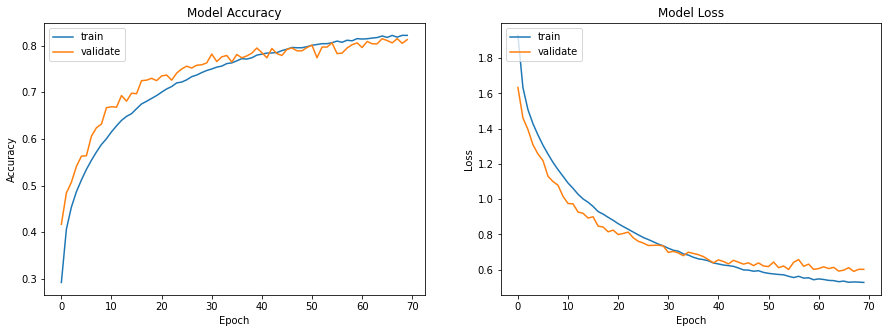

In [14]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

# Training of the OOD detector


### Creation of Heatmaps for each class

In [15]:
# Creamos una copiar de train pero shuffleada, y aquí será donde busquemos las 1000 imagenes por clase para 
seed = 8
train_images_shuffled, train_labels_shuffled = shuffle(train_images,train_labels,random_state=seed)

Option 1: Randomly

In [16]:
# Creación de array con N heatmaps por clase, para realizar clusterización sobre ellos (15 mins wide Resntet). Shape = (clases,num_heatmaps,height,width)
n_instancias = 1000
array_heatmaps_train_x_clase = n_heatmaps_x_clase(n_instancias,train_images_shuffled,train_labels_shuffled) 
cop_seg_array_heatmaps_train_x_clase = array_heatmaps_train_x_clase.copy()

Optiong 2: Only if the image was correctly predicted will be used for representing the dataset

In [17]:
# Creación de array con N heatmaps por clase, para realizar clusterización sobre ellos SOLO SI ESTAN BIEN PREDICHOS (3-4 mins)
n_instancias = 1000
predicciones_train_shuffled = np.argmax(model.predict(train_images_shuffled),axis=1)
array_heatmaps_train_x_clase_preds_buenas = n_heatmaps_x_clase_bien_predichos(n_instancias,train_images_shuffled,train_labels_shuffled,predicciones_train_shuffled)
array_heatmaps_train_x_clase = array_heatmaps_train_x_clase_preds_buenas
cop_seg_array_heatmaps_train_x_clase_preds_buenas = array_heatmaps_train_x_clase_preds_buenas.copy()

## General Approach 1: Heatmaps mean/median for each class. Calculation and ploting

In [18]:
# Creamos una lista con los heatmaps PROMEDIO o MEDIANA de cada clase

lista_htmaps_prom_x_clase  = []
modo_prom_med              = 'mediana'
for clase in range(num_clases):
  lista_htmaps_prom_x_clase.append(calculo_htmaps_promedio_mediana(array_heatmaps_train_x_clase[clase],modo=modo_prom_med))

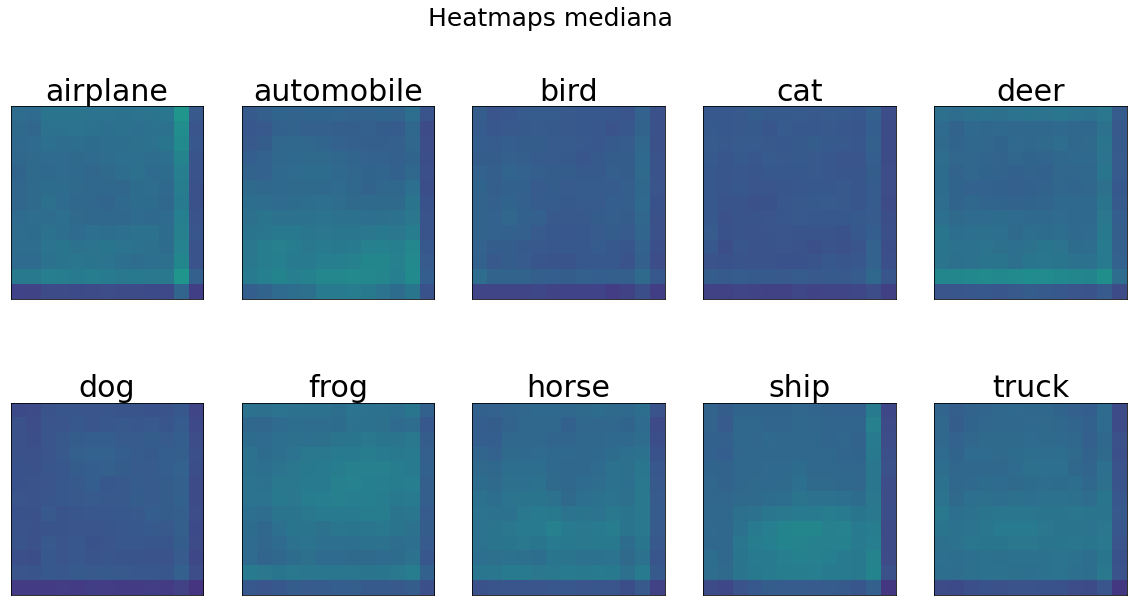

In [95]:
# Definimos si queremos reescalar el heatmap o no y si queremos representar algun numero debajo o no
rescalar_img = False
htmap_superpuestos = False

# Representamos cada uno de los heatmaps en orden
fig, ax = plt.subplots(2, 5, clear=True, figsize=[20,10])
fig.suptitle('Heatmaps {}'.format(modo_prom_med), fontsize=25)

for i in range(2):
  for j in range(5):
    indice_num = buscar_num(j+i*(5),0,train_labels_shuffled)
    img = plot_heatmap(ax,i,j,lista_htmaps_prom_x_clase[j+i*(5)],rescalar_img,title=class_names[j+i*(5)], superimposed_img = htmap_superpuestos,imagen=train_images_shuffled[indice_num,:,:,0])

'''
cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.4])
fig.colorbar(img, cax=cbar_ax)
'''
plt.savefig('./Heatmaps_{}_x_clase'.format(modo_prom_med))

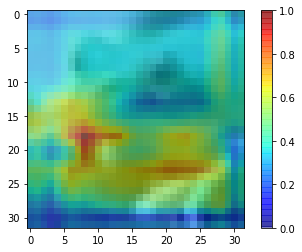

In [97]:
pos = buscar_num(6,0,train_labels_shuffled,1)
plt.imshow(train_images_shuffled[pos].squeeze(),vmin=0,vmax=1)
plt.imshow(resize(array_heatmaps_train_x_clase[8,1],(32,32)),alpha=0.5,cmap='jet',vmin=0,vmax=1)
plt.colorbar()

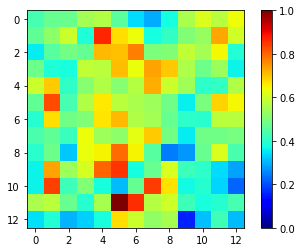

In [104]:
plt.imshow(array_heatmaps_train_x_clase[6,4],cmap='jet',vmin=0,vmax=1)
plt.colorbar()

Label:		 1
Prediccion:	 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


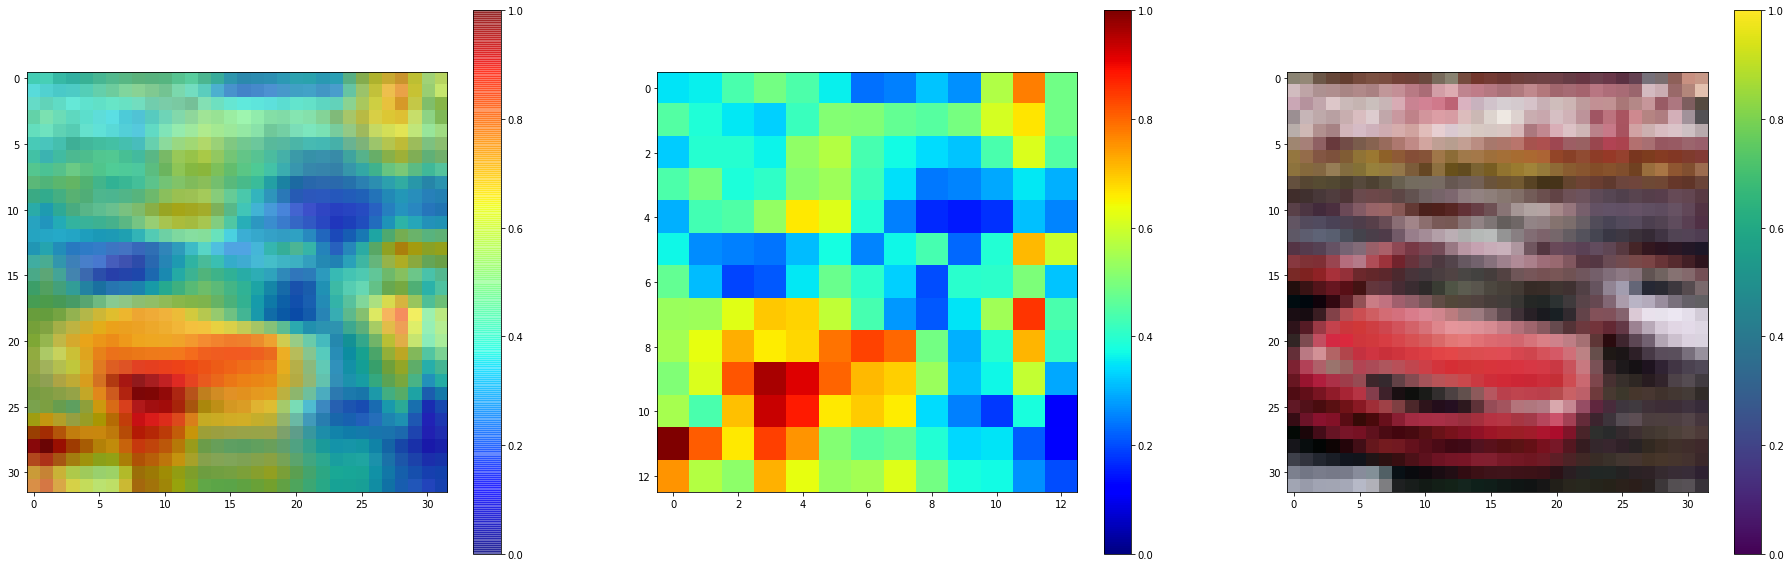

In [36]:
pos = 1543
print('Label:\t\t',np.argmax(train_labels_shuffled[pos]))
print('Prediccion:\t',np.argmax(model.predict(np.expand_dims(train_images_shuffled[pos],axis=0))))
plt.subplots(1,3,figsize=(32,10))
plt.subplot(131).imshow(train_images_shuffled[pos],vmin=0,vmax=1)
im = plt.subplot(131).imshow(resize(grad_cam_plus(train_images_shuffled[pos],model,last_conv_layer,category_id=np.argmax(train_labels_shuffled[pos])),(32,32)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
plt.colorbar(im)
im = plt.subplot(132).imshow(grad_cam_plus(train_images_shuffled[pos],model,last_conv_layer,category_id=np.argmax(train_labels_shuffled[pos])),cmap='jet',vmin=0,vmax=1)
plt.colorbar(im)
im = plt.subplot(133).imshow(train_images_shuffled[pos],vmin=0,vmax=1)
plt.colorbar(im)

plt.show()

## General Approach 2: Clusters for each class

Calculation of SSIM distances between the heatmaps of each class for clustering

In [19]:
# Creación de la matriz con los valores de SSIM por pares. Creamos matriz triangular superior (15 mins aprox)
matriz_ssim_completa = np.zeros((num_clases,array_heatmaps_train_x_clase.shape[1],array_heatmaps_train_x_clase.shape[1])) 
for clase in range(num_clases):
  matriz_ssim_completa[clase] = matriz_ssim_x_pares(array_heatmaps_train_x_clase[clase])
  print('Clase {} terminada'.format(class_names[clase]))

Clase airplane terminada
Clase automobile terminada
Clase bird terminada
Clase cat terminada
Clase deer terminada
Clase dog terminada
Clase frog terminada
Clase horse terminada
Clase ship terminada
Clase truck terminada


In [20]:
# Creamos matriz completa
matriz_ssim_completa_triang_sup = matriz_ssim_completa.copy()
for clase in range(num_clases):
  for i in range(matriz_ssim_completa[clase].shape[0]):

    for j in range(i+1,matriz_ssim_completa[clase].shape[0]):
      matriz_ssim_completa[clase,j,i] = matriz_ssim_completa[clase,i,j]

  print('Clase {} terminada'.format(class_names[clase]))

Clase airplane terminada
Clase automobile terminada
Clase bird terminada
Clase cat terminada
Clase deer terminada
Clase dog terminada
Clase frog terminada
Clase horse terminada
Clase ship terminada
Clase truck terminada


In [ ]:
# Comprobacion
print(matriz_ssim_completa[5]-np.transpose(matriz_ssim_completa[5]))
matriz_ssim_completa_triang_sup[1,25]

### Option 1: Hierarchical clustering

In [168]:
# Function that creates de clusters of each class

# Hyperparameters
distance_threshold=0.70

# Initialization of the array containing the labels of the labels for each image in each class
array_labels_agg_x_clase = np.zeros((num_clases,matriz_ssim_completa.shape[1]))

for clase in range(num_clases):
  cluster = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='complete',distance_threshold=distance_threshold)
  cluster.fit(matriz_ssim_completa_triang_sup[clase])
  array_labels_agg_x_clase[clase] = cluster.labels_

In [169]:
for clase in range(num_clases):
  a = array_labels_agg_x_clase[clase]
  unique, counts = np.unique(a, return_counts=True)
  print('Clase',class_names[clase].ljust(15),'\t',dict(zip(unique, counts)))
  print('-'*75)

Clase airplane        	 {0.0: 247, 1.0: 155, 2.0: 217, 3.0: 148, 4.0: 233}
---------------------------------------------------------------------------
Clase automobile      	 {0.0: 265, 1.0: 161, 2.0: 303, 3.0: 201, 4.0: 70}
---------------------------------------------------------------------------
Clase bird            	 {0.0: 296, 1.0: 239, 2.0: 181, 3.0: 64, 4.0: 220}
---------------------------------------------------------------------------
Clase cat             	 {0.0: 284, 1.0: 182, 2.0: 441, 3.0: 93}
---------------------------------------------------------------------------
Clase deer            	 {0.0: 444, 1.0: 222, 2.0: 215, 3.0: 119}
---------------------------------------------------------------------------
Clase dog             	 {0.0: 325, 1.0: 311, 2.0: 364}
---------------------------------------------------------------------------
Clase frog            	 {0.0: 308, 1.0: 167, 2.0: 270, 3.0: 125, 4.0: 130}
--------------------------------------------------------------

### Option 2: DBSCAN or OPTICS

In [ ]:
'''
Si hierarchical clustering no sale, habrá que probar este método
''' 

## Creation of the clusters mean/medians

Heatmaps mean/median of clusters

In [170]:
# Calculo de los heatmaps por cada cluster (0 segundos)
array_labels_de_cada_cluster  = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster = []
modo_heatmaps                     = 'mediana'
for clase in range(num_clases):
  lista_htmaps_prom_x_clase_cluster.append(calculo_htmaps_x_cluster(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=modo_heatmaps))

Heatmaps mean/median of clusters but only for the more similar heatmaps in the cluster

In [131]:
# Calculo de los heatmaps por cada cluster (0 segundos)
from tqdm import tqdm
array_labels_de_cada_cluster  = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster = []
modo_heatmaps                     = 'mediana'
threshold                         = 0.2
for clase in tqdm(range(num_clases)):
  lista_htmaps_prom_x_clase_cluster.append(calculo_htmaps_x_cluster_similares(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=modo_heatmaps,thr=threshold))
copia_seg_lista_htmaps_prom_x_clase_cluster = lista_htmaps_prom_x_clase_cluster.copy()


100%|██████████| 10/10 [14:05<00:00, 84.56s/it]


Quantile heatmaps for each cluster of each class

In [26]:
#OPTION 1
# Calculo de los heatmaps por cada cluster con CUANTILES (2 segundos)
array_labels_de_cada_cluster                = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster_cuantiles = []
modo                                        = 'cuantiles'
cuantiles                                   = [0,0.25,0.5,0.75,0.99] # SIEMPRE incluir 0 al inicio, que será la propia mediana
for clase in range(num_clases):
  lista_htmaps_prom_x_clase_cluster_cuantiles.append(calculo_htmaps_x_cluster(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=modo,cuantiles=cuantiles))

In [199]:
#OPTION 2
# Calculo de los heatmaps por cada cluster con CUANTILES (2 segundos)
array_labels_de_cada_cluster                = array_labels_agg_x_clase
lista_htmaps_prom_x_clase_cluster_cuantiles = []
quantiles_mode                              = 'mediana'
cuantiles                                   = [0,0.25,0.5,0.75,1] # SIEMPRE incluir 0 al inicio, que será la propia mediana
for clase in tqdm(range(num_clases)):
  lista_htmaps_prom_x_clase_cluster_cuantiles.append(quantile_class_heatmap_calculation(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase],modo=quantiles_mode,quantiles=cuantiles))


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Heatmaps thresholding to minimize de intercluster similarity 

In [176]:
lista_htmaps_prom_x_clase_cluster[clase].shape

(4, 13, 13)

In [184]:
# Creamos el array con los thresholds
array_thresholds = np.zeros((num_clases))

for clase in range(num_clases):
  # Definimos los minimos y maximos posibles del threshold, la aproximacion inicial y el limite del valor de threshold
  min_thr = np.max(np.min(np.min(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)) + (np.mean(lista_htmaps_prom_x_clase_cluster[clase])-np.max(np.min(np.min(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)))/2
  max_thr = np.min(np.max(np.max(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)) + (np.mean(lista_htmaps_prom_x_clase_cluster[clase])-np.min(np.max(np.max(lista_htmaps_prom_x_clase_cluster[clase],axis=2),axis=1)))/2
  thr_ini = (np.median(lista_htmaps_prom_x_clase_cluster[clase][0]))
  bounds = (min_thr,max_thr)
  

  res = minimize_scalar(similaridad, thr_ini ,args=(lista_htmaps_prom_x_clase_cluster[clase]), bounds=bounds, method='bounded')
  array_thresholds[clase] = res.x

  # Si solo hay un cluster, he cogido el valor mediana
  if lista_htmaps_prom_x_clase_cluster[clase].shape[0] == 1:
    array_thresholds[clase] = thr_ini

In [ ]:
# Aplicamos el threshold a cada clase

# Copiamos a una nueva lista los arrays para no modificarlos
lista_htmaps_prom_x_clase_cluster_threshold = []
for i,clusters in enumerate(lista_htmaps_prom_x_clase_cluster):
  lista_htmaps_prom_x_clase_cluster_threshold.append(clusters.copy())

for clase in range(num_clases):
  for i in range(len(lista_htmaps_prom_x_clase_cluster_threshold[clase])):
    
    # Aplicamos el threshold a cada centroide
    lista_htmaps_prom_x_clase_cluster_threshold[clase][i] = aplicar_threshold_a_htmap(np.copy(lista_htmaps_prom_x_clase_cluster_threshold[clase][i].copy()),array_thresholds[clase])


## Plotting the heatmaps mean/median of each CLUSTER of each CLASS

Mean/median heatmaps of the clusters


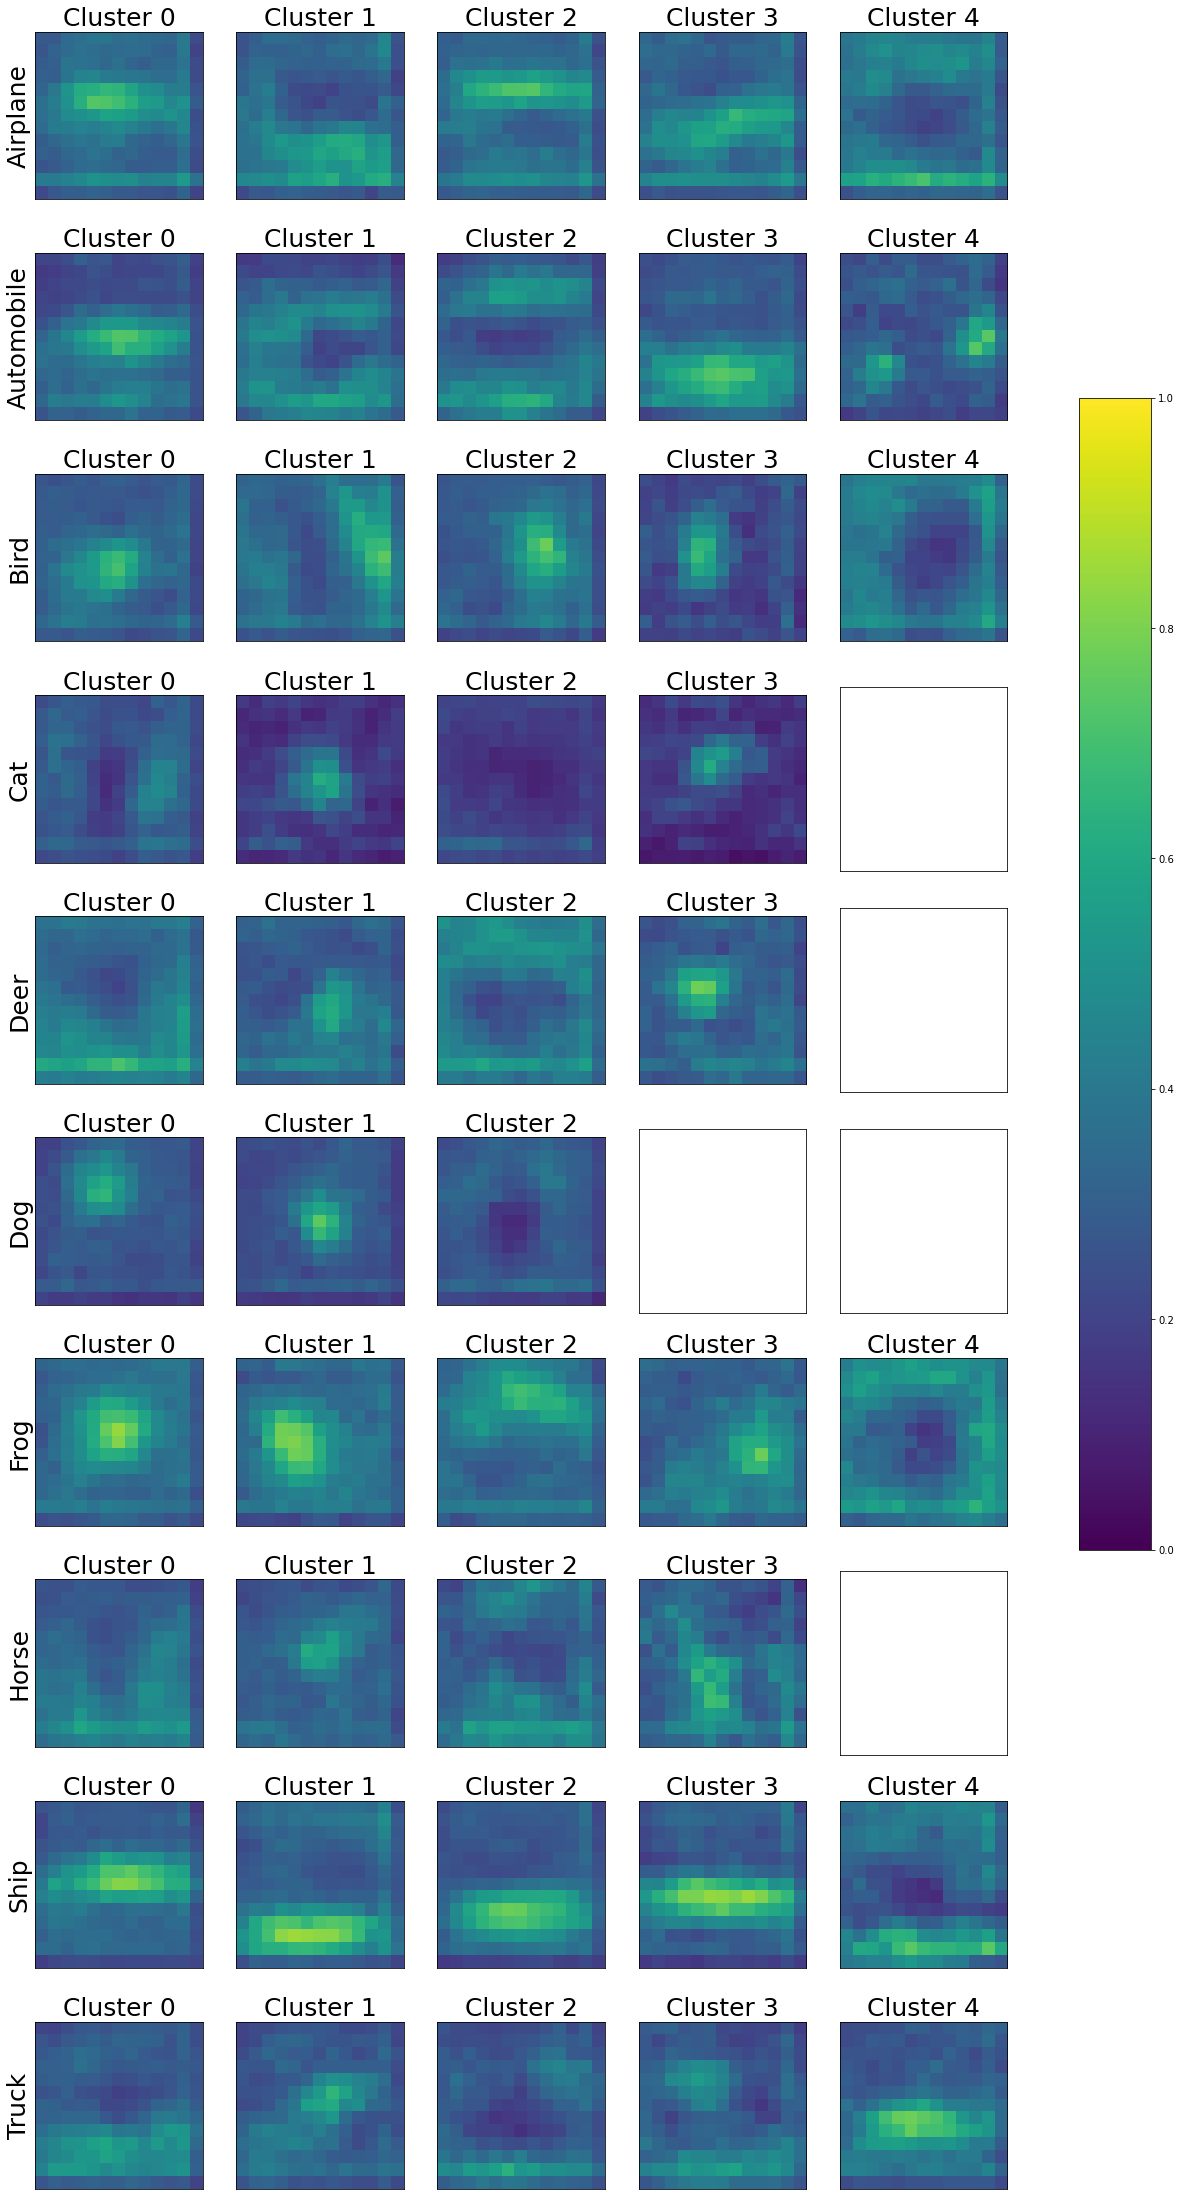

In [149]:
# Plot de los heatmaps de cada clase
superpuesto = False

# Calculo del nº max de columnas
l_max_cols = []
for htmap_prom_cluster in lista_htmaps_prom_x_clase_cluster:
  l_max_cols.append(len(htmap_prom_cluster))
max_cols= max(l_max_cols)

# Plots
fig, ax = plt.subplots(nrows=num_clases,ncols=max_cols, figsize = (4*max_cols,8*max_cols),sharex=True,sharey=True)
for clase in range(num_clases):

  for cluster in range(len(lista_htmaps_prom_x_clase_cluster[clase])):
    
    if superpuesto == False:
      im = ax[clase,cluster].imshow(lista_htmaps_prom_x_clase_cluster[clase][cluster],vmin=0,vmax=1)
      
    elif superpuesto == True:
      indice_num = buscar_num(clase,0,train_labels_shuffled)
      ax[clase,cluster].imshow(train_images_shuffled[indice_num[0],:,:,0])
      im = ax[clase,cluster].imshow(resize(lista_htmaps_prom_x_clase_cluster[clase][cluster],(train_images_shuffled.shape[1:3])),alpha = 0.6,cmap='jet',vmin=0,vmax=1) # Guardo la AxesImage para tener el colorbar

    ax[clase,cluster].set_title('Cluster {}'.format(cluster),fontsize=25)
    ax[clase,cluster].set_xticks([])
    ax[clase,cluster].set_yticks([])
    #ax[clase,cluster].axis('off')

    if cluster == 0:
      ax[clase,cluster].set_ylabel(class_names[clase].title(),rotation = 90, fontsize=25)


fig.subplots_adjust(right=0.80)
cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.4])
fig.colorbar(im, cax=cbar_ax)
# fig.colorbar(cm.ScalarMappable(norm= colors.Normalize(vmin=0, vmax=1), cmap='jet'), cax=cbar_ax) con esto pones tu la escala de colores

#fig.colorbar(cm.ScalarMappable(norm=None, cmap='jet'), ax=ax[0,0])


plt.savefig('./Heatmaps_x_clase_y_cluster_{}'.format(modo_heatmaps),dpi=40)

Quantile heatmaps

In [200]:
# Plot de los heatmaps de cada clase
superpuesto = True

# Calculo del nº max de columnas



# Plots
for clase in range(num_clases):
  n_clusters     = lista_htmaps_prom_x_clase_cluster_cuantiles[clase].shape[0]
  n_cuantiles    = lista_htmaps_prom_x_clase_cluster_cuantiles[clase].shape[1]
  fig, ax = plt.subplots(nrows=n_clusters,ncols=n_cuantiles, figsize = (n_cuantiles*5,n_clusters*2.5),sharex=True,sharey=True)
  for cluster in range(n_clusters):
    for cuantil in range(n_cuantiles):
        
      if superpuesto == False:
        ax[cluster,cuantil].imshow(lista_htmaps_prom_x_clase_cluster_cuantiles[clase][cluster,cuantil])
        ax[cluster,cuantil].set_title('cuantil {}'.format(cuantiles[cuantil]),fontsize=25)
        ax[cluster,cuantil].set_xticks([])
        ax[cluster,cuantil].set_yticks([])

      elif superpuesto == True:
        indice_num = buscar_num(clase,0,train_labels_shuffled)
        ax[cluster,cuantil].imshow(train_images_shuffled[indice_num[0],:,:,0])
        im = ax[cluster,cuantil].imshow(resize(lista_htmaps_prom_x_clase_cluster_cuantiles[clase][cluster,cuantil],(28,28)),alpha = 0.6,cmap='jet',vmin=0,vmax=1) # Guardo la AxesImage para tener el colorbar
        ax[cluster,cuantil].set_xticks([])
        ax[cluster,cuantil].set_yticks([])
        if cluster ==0:
          if cuantil==0:
            ax[cluster,cuantil].set_title('Mediana'.format(cuantiles[cuantil]),fontsize=25)
          else:
            ax[cluster,cuantil].set_title('Cuantil {}'.format(cuantiles[cuantil]),fontsize=25)

  fig.suptitle('Clase {}'.format(class_names[clase]),x=0.1,y=0.55,rotation=90,fontsize=20)
  fig.subplots_adjust(right=0.80)
  cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.4])
  fig.colorbar(im, cax=cbar_ax)


  # fig.colorbar(cm.ScalarMappable(norm= colors.Normalize(vmin=0, vmax=1), cmap='jet'), cax=cbar_ax) con esto pones tu la escala de colores

  #fig.colorbar(cm.ScalarMappable(norm=None, cmap='jet'), ax=ax[0,0])

  plt.savefig('./Heatmaps_x_Cuantil_y_Cluster_{}'.format(clase))
  plt.close(fig)

fig , axs = plt.subplots(nrows=num_clases,ncols=1,constrained_layout=True, figsize=(25, 85))
fig.suptitle('Plot de cada cuantil de cada cluster de cada clase',y=0.995,fontsize=20)
for i_fig in range(num_clases):

  plot = io.imread('./Heatmaps_x_Cuantil_y_Cluster_{}.png'.format(i_fig))/255.0
  axs[i_fig].imshow(plot,vmin=0,vmax=1)
  axs[i_fig].axis("off")

plt.savefig('./Heatmaps_x_Cuantil_y_Cluster_Completo')

Output hidden; open in https://colab.research.google.com to view.

Thresholded heatmaps

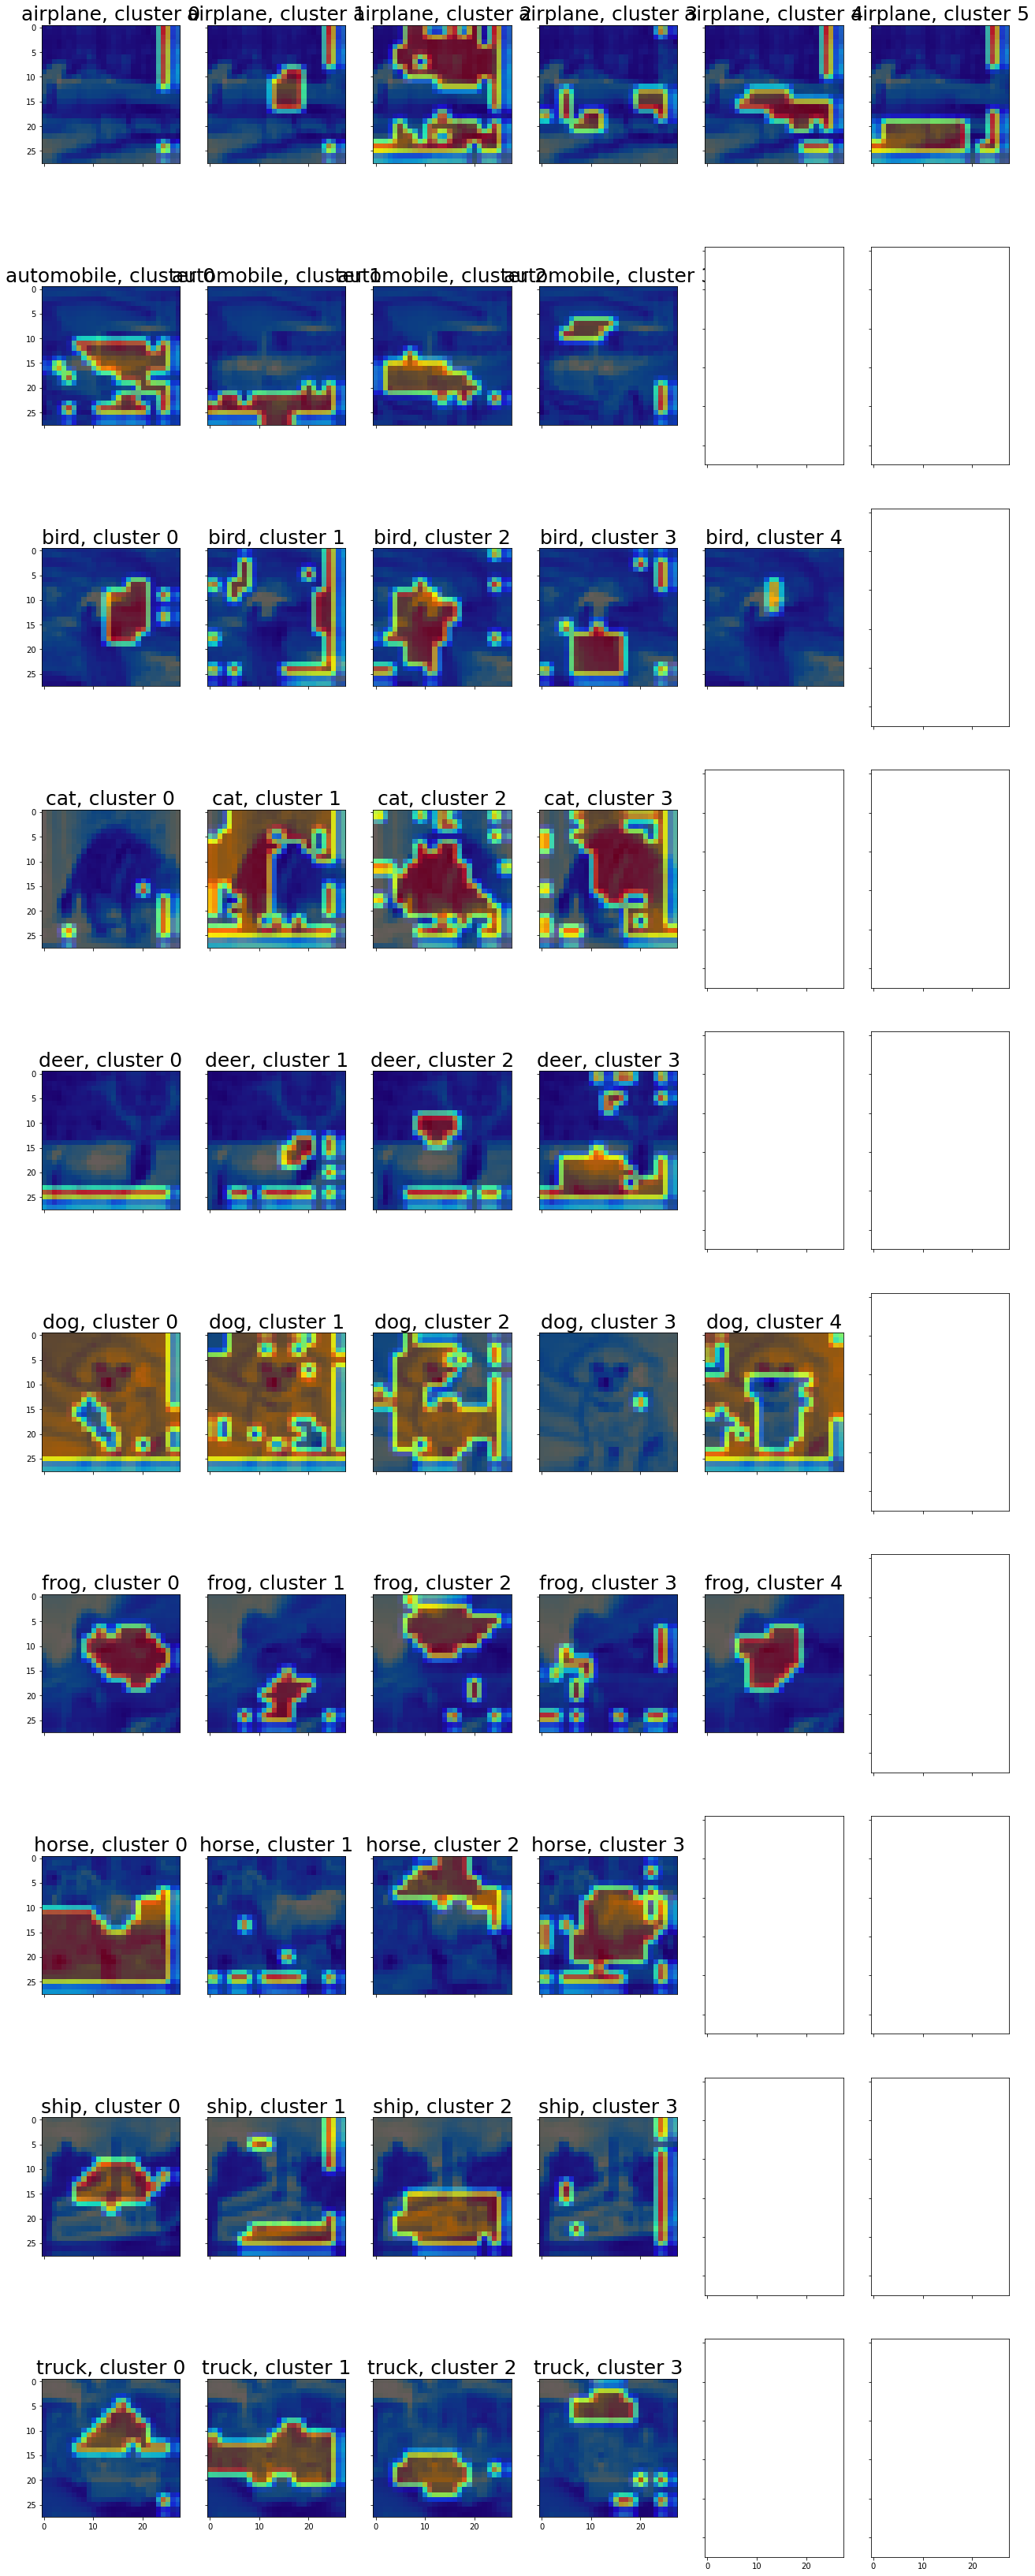

In [190]:
# Plot de los heatmaps de cada clase

superpuesto = True

# Calculo del nº max de columnas
l_max_cols = []
for htmap_prom_cluster in lista_htmaps_prom_x_clase_cluster_threshold:
  l_max_cols.append(len(htmap_prom_cluster))
max_cols= max(l_max_cols)

# Plots
fig, ax = plt.subplots(nrows=num_clases,ncols=max_cols, figsize = (22,60),sharex=True,sharey=True)
for clase in range(num_clases):

  for cluster in range(len(lista_htmaps_prom_x_clase_cluster_threshold[clase])):
    
    if superpuesto == False:
      ax[clase,cluster].imshow(lista_htmaps_prom_x_clase_cluster_threshold[clase][cluster])
      ax[clase,cluster].set_title('{}, cluster {}'.format(class_names[clase],cluster),fontsize=25)
    elif superpuesto == True:
      indice_num = buscar_num(clase,0,train_labels_shuffled)
      ax[clase,cluster].imshow(train_images_shuffled[indice_num[0],:,:,0])
      ax[clase,cluster].imshow(resize(lista_htmaps_prom_x_clase_cluster_threshold[clase][cluster],(28,28)),alpha = 0.6,cmap='jet',vmin=0,vmax=1)
      ax[clase,cluster].set_title('{}, cluster {}'.format(class_names[clase],cluster),fontsize=25)
    
plt.savefig('./Heatmaps_x_clase_x_cluster_threshold')

# Inference

## Train, Test and OD dataset heatmap creation

Train and Test heatmaps creation

In [21]:
# Calculamos los heatmaps de imagenes de test (3 mins aprox)
predicciones_train = np.argmax(model.predict(train_images_shuffled[-10000:]),axis=1)
array_htmaps_train = calculo_htmaps(train_images_shuffled[-10000:],predicciones_train)

In [150]:
# Calculamos los heatmaps de imagenes de test (3 mins aprox)
predicciones_test = np.argmax(model.predict(test_images),axis=1)
array_htmaps_test = calculo_htmaps(test_images,predicciones_test)

OD Dataset selection and heatmap creation

In [181]:
# Load the desired OD dataset
OD_dataset = 'SVHN_cropped'

if OD_dataset == 'SVHN_cropped':

  od_test_images, od_test_labels = load_svhn('/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Datasets/SVHN_Cropped')
  np.random.shuffle(od_test_images,seed=15)
  od_test_images = od_test_images[:10000]

Loading SVHN dataset.


In [182]:
# Calculamos los heatmaps de imagenes de test (3 mins aprox para 10.000 imagenes)
predicciones_od = np.argmax(model.predict(od_test_images),axis=1)
array_htmaps_od = calculo_htmaps(od_test_images,predicciones_od)

## Comparing method selection

### General approach 1

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_train = calculo_ssim_prom_med(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase)

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_test = calculo_ssim_prom_med(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase)

In [ ]:
# Calculo del SSIM contra el htmap prom o mediana de su clase predicha
array_ssim_x_imagen_od = calculo_ssim_prom_med(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase)

### General approach 2

SSIM against clusters mean/median

In [171]:
# Calculamos el SSIM de cada htmap contra su correspondiente CLUSTER
array_ssim_x_imagen_train = calculo_ssim(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [172]:
# Calculamos el SSIM de cada htmap contra su correspondiente CLUSTER
array_ssim_x_imagen_test = calculo_ssim(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster)

In [184]:
# Calculamos el SSIM de cada htmap contra su correspondiente CLUSTER
array_ssim_x_imagen_od = calculo_ssim(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

MSE against clusters mean/median

In [ ]:
# MSE
array_ssim_x_imagen_train = calculo_mse(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# MSE
array_ssim_x_imagen_test = calculo_mse(array_htmaps_test,predicciones,lista_htmaps_prom_x_clase_cluster)

In [ ]:
# MSE
array_ssim_x_imagen_od = calculo_mse(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

SSIM against all the heatmaps of the closest cluster

In [67]:
# SSIM o MSE para el heatmap más cercano del cluster más cercano (17 mins aprox para 10.000 imagenes)
array_labels_de_cada_cluster = array_labels_agg_x_clase
metodo = 'ssim'
array_ssim_x_imagen_train = calculo_distancia_htmap_cercano(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster,array_heatmaps_train_x_clase,array_labels_de_cada_cluster,metodo=metodo)
array_copia_seg_train = array_ssim_x_imagen_train.copy()

In [68]:
# SSIM o MSE para el heatmap más cercano del cluster más cercano (17 mins aprox para 10.000 imagenes)
array_labels_de_cada_cluster = array_labels_agg_x_clase
metodo = 'ssim'
array_ssim_x_imagen_test = calculo_distancia_htmap_cercano(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster,array_heatmaps_train_x_clase,array_labels_de_cada_cluster,metodo=metodo)
array_copia_seg_test = array_ssim_x_imagen_test.copy()

In [69]:
# SSIM o MSE para el heatmap más cercano del cluster más cercano (17 mins aprox para 10.000 imagenes)
array_labels_de_cada_cluster = array_labels_agg_x_clase
metodo = 'ssim'
array_ssim_x_imagen_od = calculo_distancia_htmap_cercano(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster,array_heatmaps_train_x_clase,array_labels_de_cada_cluster,metodo=metodo)
array_copia_seg_od = array_ssim_x_imagen_od.copy()

SSIM against the clusters quantiles

In [41]:
# SSIM o MSE para los CUANTILES definidos del cluster más cercano (25s)
metodo = 'ssim'
array_ssim_x_imagen_train = calculo_distancia_htmap_cuantiles(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster_cuantiles,metodo=metodo)

In [42]:
# SSIM o MSE para los CUANTILES definidos del cluster más cercano (25s)
metodo = 'ssim'
array_ssim_x_imagen_test = calculo_distancia_htmap_cuantiles(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster_cuantiles,metodo=metodo)

In [43]:
# SSIM o MSE para los CUANTILES definidos del cluster más cercano (25s)
metodo = 'ssim'
array_ssim_x_imagen_od = calculo_distancia_htmap_cuantiles(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster_cuantiles,metodo=metodo)

SSIM against reescaled cluster heatmaps

Option 1:

In [57]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO (10s)
array_ssim_x_imagen_train = calculo_ssim_reescalado(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [58]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO
array_ssim_x_imagen_test = calculo_ssim_reescalado(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster)

In [59]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO
array_ssim_x_imagen_od = calculo_ssim_reescalado(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

Option 2:

In [66]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO (10s) pero se reescala el input
array_ssim_x_imagen_train,array_htmaps_train_reesc = calculo_ssim_reescalado_a_input(array_htmaps_train,predicciones_train,lista_htmaps_prom_x_clase_cluster)

In [67]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO pero se reescala el input
array_ssim_x_imagen_test,array_htmaps_test_reesc = calculo_ssim_reescalado_a_input(array_htmaps_test,predicciones_test,lista_htmaps_prom_x_clase_cluster)

In [68]:
# Calculamos el SSIM de cada htmap contra su correspondiente con REESCALADO pero se reescala el input
array_ssim_x_imagen_od,array_htmaps_od_reesc = calculo_ssim_reescalado_a_input(array_htmaps_od,predicciones_od,lista_htmaps_prom_x_clase_cluster)

## SSIM array to DataFrame conversion

In [174]:
df_ssim_x_imagen_train = pd.DataFrame(array_ssim_x_imagen_train,columns=['SSIM','Clase_pred'])

In [175]:
df_ssim_x_imagen_test = pd.DataFrame(array_ssim_x_imagen_test,columns=['SSIM','Clase_pred'])

In [185]:
df_ssim_x_imagen_od = pd.DataFrame(array_ssim_x_imagen_od,columns=['SSIM','Clase_pred'])

## Threshold and OOD cheking


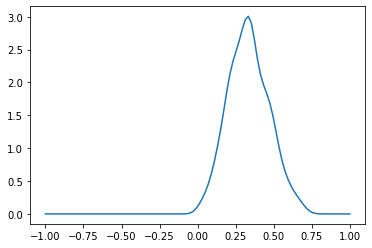

In [157]:

kde_sci_pruebas = stats.gaussian_kde(np.array(df_ssim_x_imagen_train['SSIM'].loc[df_ssim_x_imagen_train['Clase_pred']==1]))
x = np.linspace(-1,1,100)
array_pdf_logpdf = np.zeros((x.shape))
for i,x_0 in enumerate(x):
  array_pdf_logpdf[i] = (kde_sci_pruebas.pdf(x_0))

plt.plot(x,array_pdf_logpdf)

In [ ]:
# Genera el threshold adecuado para cada clase en funcion de un TPR (True Positive Rate) que queramos conseguir.
# El TPR es el porcentaje de imagenes de la In-Distribution que se clasificarán como True (que efectivamente son de la In-D)

tpr_ini         = 0.95
modo_de_calculo = 'SSIM'
lista_kde_thr_x_clase = calculo_kde_thresholds(tpr_ini,df_ssim_x_imagen_train,modo=modo_de_calculo)

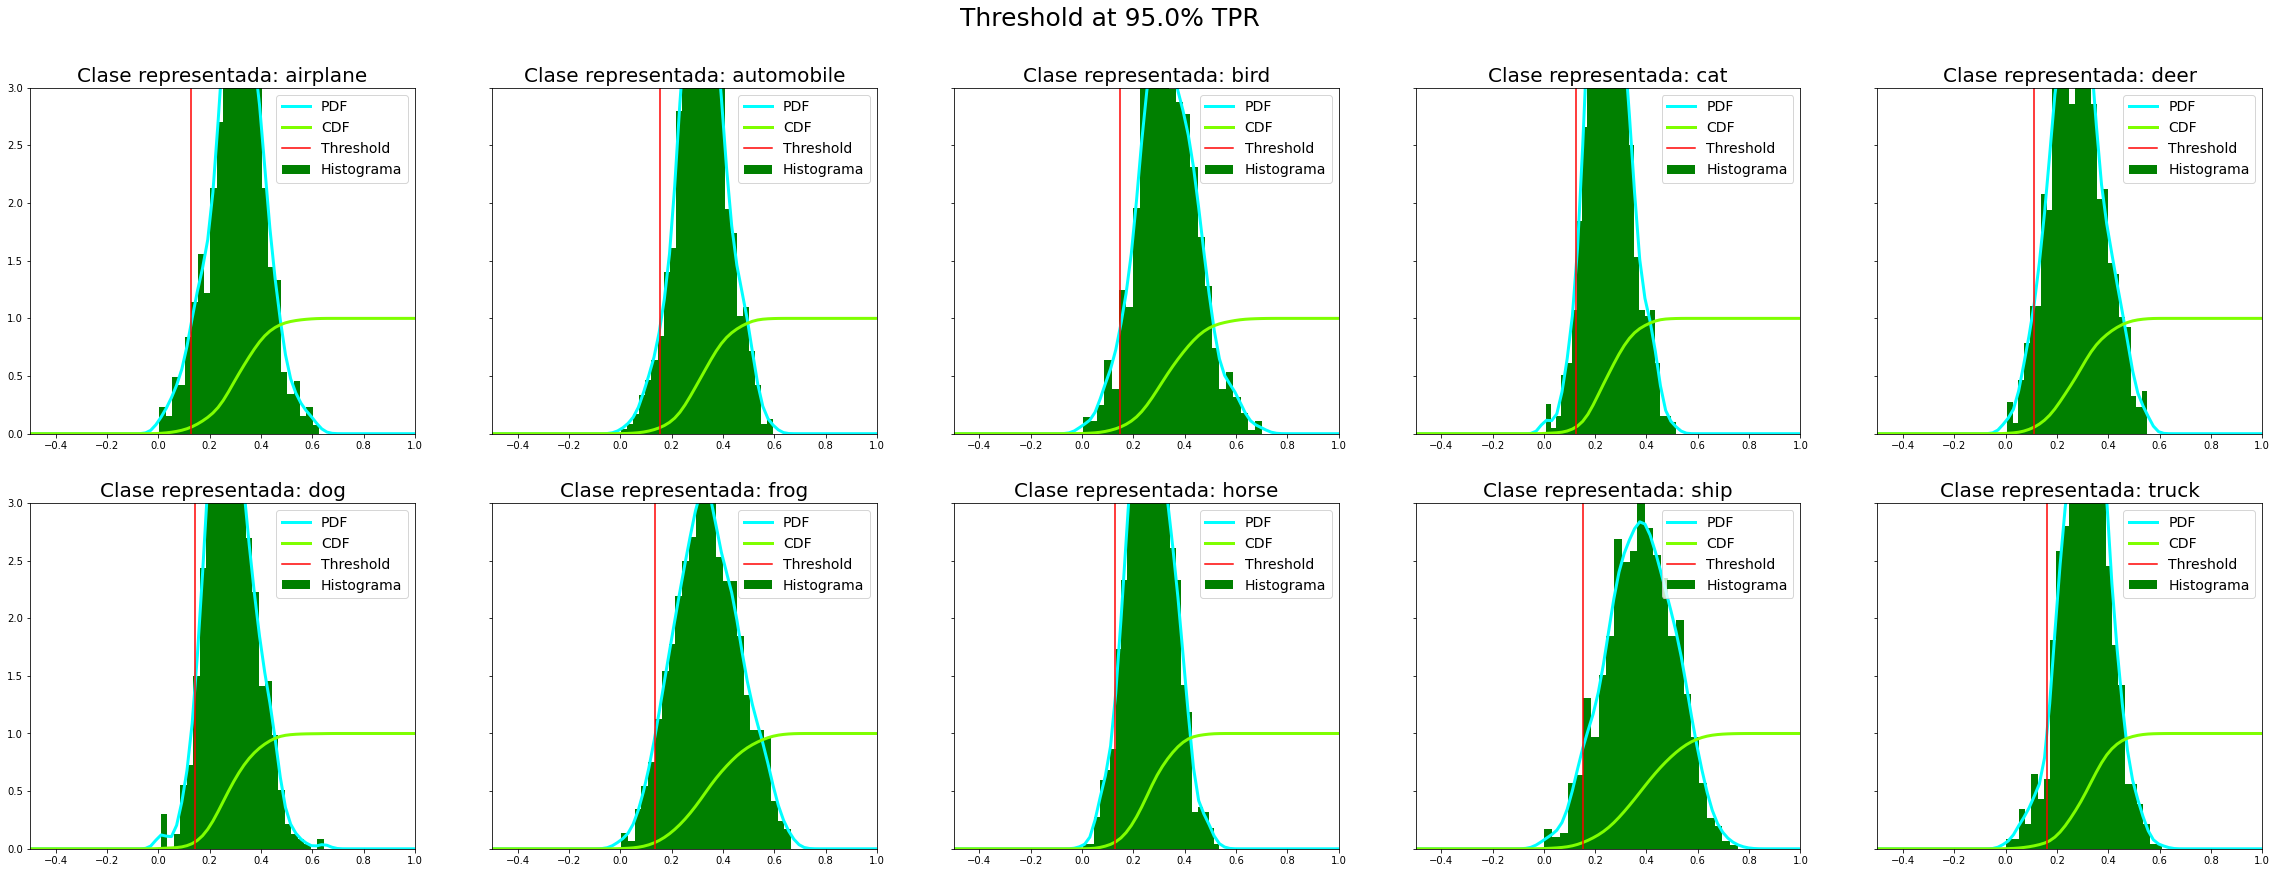

In [ ]:
# Funcion que representa el threshold 

# Elegimos
df_plot = df_ssim_x_imagen_train

x = np.linspace(-1,1,100)
y = np.linspace(1,-1,100)

fig, ax = plt.subplots(2,5,sharey=True,figsize=(40,14))
fig.suptitle('Threshold at {}% TPR'.format(tpr_ini*100), fontsize=25,y=0.96)

for num in range(10):

  # KDE fitting
  kde_sci = lista_kde_thr_x_clase[num][0]
  cdf = []
  for i in x:
    cdf.append(kde_sci.integrate_box_1d(-1,i))
  
  # Definicion de i y j para plotear bien
  i=0
  j=num
  if num >= 5:
    i = 1
    j = num-5

  # Plots de KDE
  ax[i,j].set_xlim((-0.5,1))
  ax[i,j].set_ylim((0,3))
  ax[i,j].hist(df_plot['SSIM'].loc[df_plot['Clase_pred']==num], density=True,bins=25,color='green',label='Histograma')
  
  ax[i,j].plot(x, kde_sci.pdf(x), lw=3, label='PDF', color='cyan',zorder=1)
  ax[i,j].plot(x, cdf, lw=3, label='CDF', color='chartreuse',zorder=2)
  ax[i,j].set_title('Clase representada: {}'.format(class_names[num]),fontsize=20)
  ax[i,j].axvline(x=lista_kde_thr_x_clase[num][1], ymin=0, ymax=1,color='red',label='Threshold')

  ax[i,j].legend(fontsize=14, loc='upper right')


## Metrics

### Ploting histograms

In [177]:
df_ssim_x_imagen_train.median()

SSIM          0.244348
Clase_pred    5.000000
dtype: float64

In [178]:
df_ssim_x_imagen_test.median()

SSIM          0.242769
Clase_pred    5.000000
dtype: float64

In [186]:
df_ssim_x_imagen_od.median()

SSIM          0.218394
Clase_pred    3.000000
dtype: float64

In [161]:
# Para que funcione el codigo de debajo
df_comp        = df_ssim_x_imagen_test # Plot verde
df_comp_gir    = df_ssim_x_imagen_od # Plot rojo

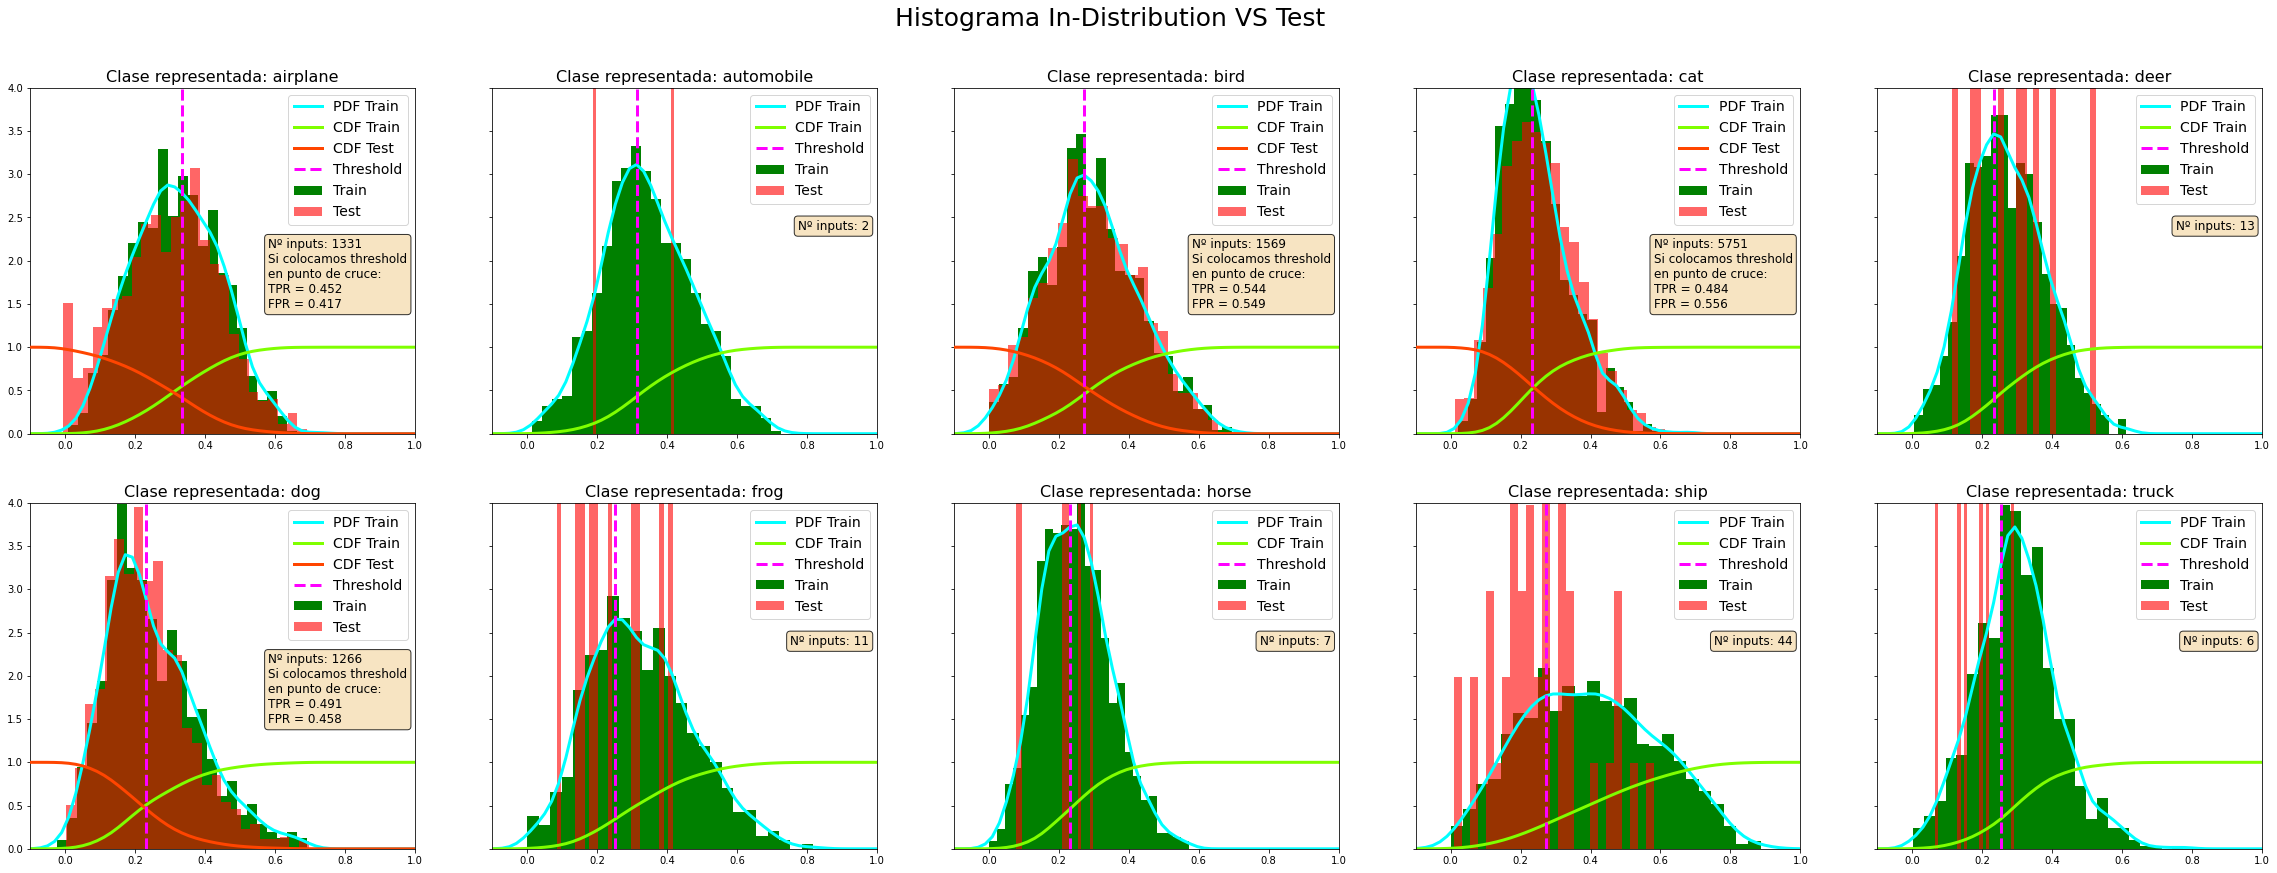

In [162]:
# Funcion que representa el % de instancias que SI activan el threshold tanto CON como SIN deriva 

# Inicializar los rangos para los que se calcula la CDF
x = np.linspace(-1,1,100)
y = np.linspace(1,-1,100)

# Propiedades de la caja donde va el texto
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# Creacion de figura
fig, ax = plt.subplots(2,5,sharey=True,figsize=(40,14))
plot_verde  = 'Train'   
plot_rojo   = 'Test'
fig.suptitle('Histograma In-Distribution VS {}'.format(plot_rojo), fontsize=25,y=0.96)

for num in range(10):

  # KDE fitting
  kde_sci = stats.gaussian_kde(np.array(df_comp['SSIM'].loc[df_comp['Clase_pred']==num]))
  cdf = []
  for i in x:
    cdf.append(kde_sci.integrate_box_1d(-1,i))

  # KDE fitting
  if df_comp_gir['Clase_pred'].value_counts()[num] > 50:
    kde_sci_OOD = stats.gaussian_kde(np.array(df_comp_gir['SSIM'].loc[df_comp_gir['Clase_pred']==num]))
    cdf_OOD = []
    for i in y:
      cdf_OOD.append(kde_sci_OOD.integrate_box_1d(i,1))

  # Calculo del punto de cruce minimizando diferencia entre CDFs. La solucion nos da la posicion del punto de minima 
  # diferencia dentro del array, no el valor en si
  sol = minimize_scalar(diferencia_cdf,args=(kde_sci,kde_sci_OOD),method='bounded',bounds=(1,99),options={'xatol': 0.001,'maxiter': 100, 'disp': 0})

  # Punto de cruce es el valor del eje X en la posicion de la solucion 
  p_cruce = x[int(sol.x)]
  tpr_cruce = round(kde_sci.integrate_box_1d(p_cruce,1),3)
  fpr_cruce = round(1-kde_sci_OOD.integrate_box_1d(-1,p_cruce),3)
  
  # Definicion de i y j para plotear bien
  i=0
  j=num
  if num >= 5:
    i = 1
    j = num-5

  # Plots de KDE
  ax[i,j].set_xlim((-0.1,1))
  ax[i,j].set_ylim((0,4))
  ax[i,j].hist(df_comp['SSIM'].loc[df_comp['Clase_pred']==num], density=True,bins=25,color='green',label=plot_verde)
  ax[i,j].hist(df_comp_gir['SSIM'].loc[df_comp_gir['Clase_pred']==num], density=True,bins=25,color='red',alpha=0.6,label=plot_rojo)
  ax[i,j].plot(x, kde_sci.pdf(x), lw=3, label='PDF {}'.format(plot_verde), color='cyan',zorder=1)
  ax[i,j].plot(x, cdf, lw=3, label='CDF {}'.format(plot_verde), color='chartreuse',zorder=2)
  ax[i,j].set_title('Clase representada: {}'.format(class_names[num]),fontsize=16)

  if df_comp_gir['Clase_pred'].value_counts()[num] > 50:
    ax[i,j].plot(y, cdf_OOD, lw=3, label='CDF {}'.format(plot_rojo), color='orangered',zorder=3)
    # Texto
    textstr = 'Nº inputs: {}\nSi colocamos threshold\nen punto de cruce:\nTPR = {}\nFPR = {}'.format(df_comp_gir['Clase_pred'].value_counts()[num],tpr_cruce,fpr_cruce)
    ax[i,j].text(0.98, 0.46, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
  else:
    try:
      textstr = 'Nº inputs: {}'.format(df_comp_gir['Clase_pred'].value_counts()[num])
      ax[i,j].text(0.98, 0.60, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)
    except:
      textstr = 'Nº inputs: 0'
      ax[i,j].text(0.98, 0.60, textstr, transform=ax[i,j].transAxes, fontsize=12,horizontalalignment='right',verticalalignment='center', multialignment='left',bbox=props,zorder=4)

  ax[i,j].axvline(x=p_cruce, ymin=0, ymax=1,color='fuchsia',label='Threshold',linewidth=3,linestyle='--',zorder=5)
  ax[i,j].legend(fontsize=14, loc='upper right')

fig.savefig('./Hist_{}_vs_{}'.format(plot_verde,plot_rojo),dpi=200)
#ax[i,j].text(0.69,2.38,'Nº inputs: {}'.format(df_comp_gir['Clase_pred'].value_counts()[num]),fontsize=12)
#ax[i,j].text(0.61,1.9,'''Si colocamos threshold en punto de cruce: TPR = {} TNR = {} '''.format(tpr_cruce,tnr_cruce),fontsize=10)

### Threshold independent metrics data calculation (Test_images VS Out-Distribution)

In [163]:
# Calculo de los thresholds que se van a emplear para las metricas independientes del threshold (50s)

# Eleccion del DataFrame que se va a usar para generar los KDEs (DEBE SER TRAIN)
df_kde = df_ssim_x_imagen_train

# SSIM o MSE
modo_de_calculo = 'SSIM'

# Inicializar array con todos los tprs y la lista con los thresholds 
array_full_tpr                = np.linspace(0,0.99,100)
array_full_thresholds         = np.zeros((len(array_full_tpr),num_clases))
array_thresholds_cols_to_rows = np.zeros(())

for ind,true_positive_rate in enumerate(array_full_tpr):

  lista_kde_threshold_variando = calculo_kde_thresholds(true_positive_rate,df_kde,modo_de_calculo)
  
  array_thresholds_cols_to_rows = np.zeros((num_clases))
  for i,kde_thr in enumerate(lista_kde_threshold_variando):
    array_thresholds_cols_to_rows[i] = kde_thr[1]
  
  array_full_thresholds[ind] = array_thresholds_cols_to_rows

In [164]:
# Generacion de array sobre la In-Distribution con valores True o False sobre si son (True) o no (False) parte de la distribucion 
# Inicializaciones
array_InD              = array_ssim_x_imagen_test
preds_InD              = predicciones_test
array_InD_x_threshold  = np.empty((len(array_InD),len(array_full_tpr)),dtype=bool)

# Progress bar
bar = progressbar.ProgressBar(maxval=len(array_full_thresholds),widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()
n = 0

# Inicializamos el tiempo
t3 = timeit.default_timer() 
for i_thr,threshold in enumerate(array_full_thresholds):

  for i_imagen,ssim_calculado in enumerate(array_InD):
    array_InD_x_threshold[i_imagen,i_thr] = comprobacion_OOD(ssim_calculado[0],array_full_thresholds[preds_InD[i_imagen]],threshold[preds_InD[i_imagen]])

  bar.update(n)
  n = n+1

df_InD = pd.DataFrame(array_InD_x_threshold)

t4 = timeit.default_timer() 
print('\nThresholds time: {}'.format(t4 - t3))
print('Fin')

[=================================================================  ] 98 of 100


Thresholds time: 1.7867830510003841
Fin


In [165]:
# Generacion de array sobre la Out-Distribution con valores True o False sobre si son (True) o no (False) parte de la distribucion ( s aprox)

# Inicializaciones
array_OutD              = array_ssim_x_imagen_od
preds_OutD              = predicciones_od
array_OutD_x_threshold  = np.zeros((len(array_OutD),len(array_full_tpr)),dtype=bool)

# Progress bar
bar = progressbar.ProgressBar(maxval=len(array_full_thresholds),widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()
n = 0

# Inicializamos el tiempo
t3 = timeit.default_timer() 
for i_thr,threshold in enumerate(array_full_thresholds):

  for i_imagen,ssim_calculado in enumerate(array_OutD):
    array_OutD_x_threshold[i_imagen,i_thr] = comprobacion_OOD(ssim_calculado[0],array_full_thresholds[preds_OutD[i_imagen]],threshold[preds_OutD[i_imagen]])

  bar.update(n)
  n = n+1

df_OutD = pd.DataFrame(array_OutD_x_threshold)

t4 = timeit.default_timer() 
print('\nThresholds time: {}'.format(t4 - t3))
print('Fin')

[=================================================================  ] 98 of 100


Thresholds time: 1.8094923490061774
Fin


### AUROC

In [166]:
# Creacion de un array con el TPR y el FPR

# Inicializar array
array_TPR_FPR_x_threshold = np.empty((len(df_InD.columns),2))

for i,thr in enumerate(df_InD.columns):

  # Por cada threshold sacamos los que son True y False de cada distribucion
  values_InD  = df_InD[thr].value_counts()
  values_OutD = df_OutD[thr].value_counts()
  
  try:
    tp  = values_InD[True]
  except:
    tp = 0  
  try:
    fn  = values_InD[False]
  except:
    fn = 0
  tpr = tp/(tp+fn)

  try:
    fp = values_OutD[True]
  except:
    fp = 0
  tn = values_OutD[False]
  fpr = fp/(fp+tn)

  #print((tp+fn),(fp+tn))
  array_TPR_FPR_x_threshold[i] = np.array([tpr,fpr])

array_TPR_FPR_x_threshold = np.append(array_TPR_FPR_x_threshold,np.reshape(np.array([1,1]),(1,2)),axis=0) # He añadido para cerrar la curva

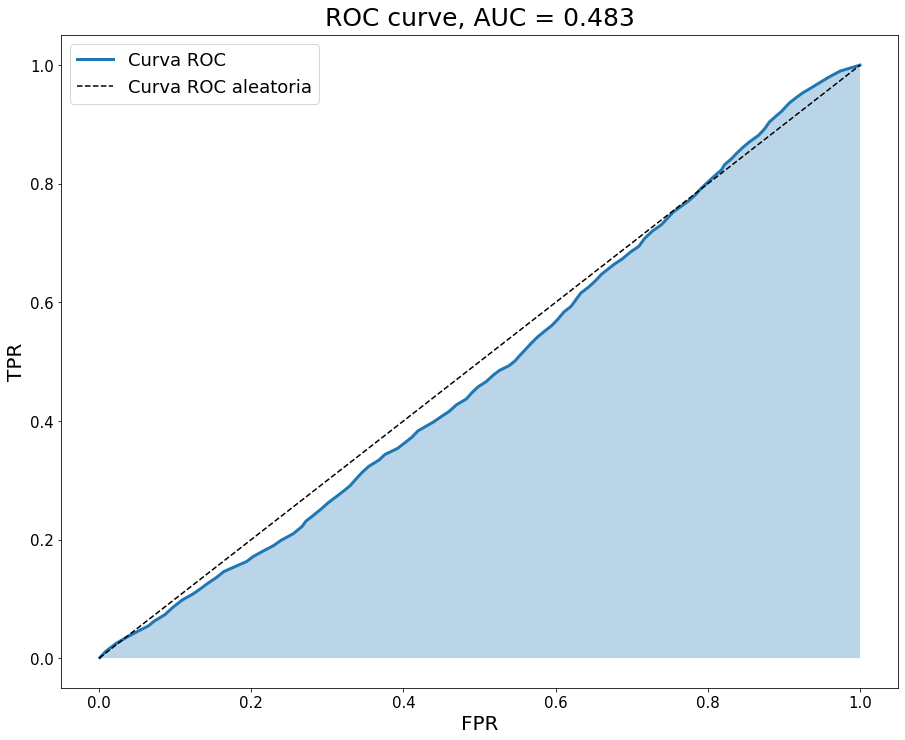

In [167]:
# Calculo del AUC
auc = np.trapz(array_TPR_FPR_x_threshold[:,0], array_TPR_FPR_x_threshold[:,1])

# Plot
plt.figure(figsize=(15,12))
plt.plot(array_TPR_FPR_x_threshold[:,1],array_TPR_FPR_x_threshold[:,0],label='Curva ROC',lw=3)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'k--',label='Curva ROC aleatoria')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.title('ROC curve, AUC = %.3f'%auc,fontsize=25,pad=10)
plt.fill_between(array_TPR_FPR_x_threshold[:,1],array_TPR_FPR_x_threshold[:,0],alpha=0.3)
plt.legend(fontsize=18)
plt.savefig('/content/AUROC_Fashion_vs_MNIST')

### AUPR


In [78]:
# Calculo de la Precision (tp/(tp+fp)) y el Recall (tp/(tp+fn))

# Inicializar array
array_Prec_Recall_x_threshold = np.empty((len(df_InD.columns),2))

for i,thr in enumerate(df_InD.columns):

  # Por cada threshold sacamos los que son True y False de cada distribucion
  values_InD  = df_InD[thr].value_counts()
  values_OutD = df_OutD[thr].value_counts()

  try:
    tp  = values_InD[True]
  except:
    tp = 0
  try:
    fp = values_OutD[True]
  except:
    fp = 0
  try:
    prec = tp/(tp+fp)
  except:
    prec = 1

  try:
    fn = values_InD[False]
  except:
    fn = 0
  recal_tpr = tp/(tp+fn)

  array_Prec_Recall_x_threshold[i] = np.array([prec,recal_tpr])

array_Prec_Recall_x_threshold[0] = np.array([1,0])
#lista_Prec_Recall_x_threshold.append([1,0])

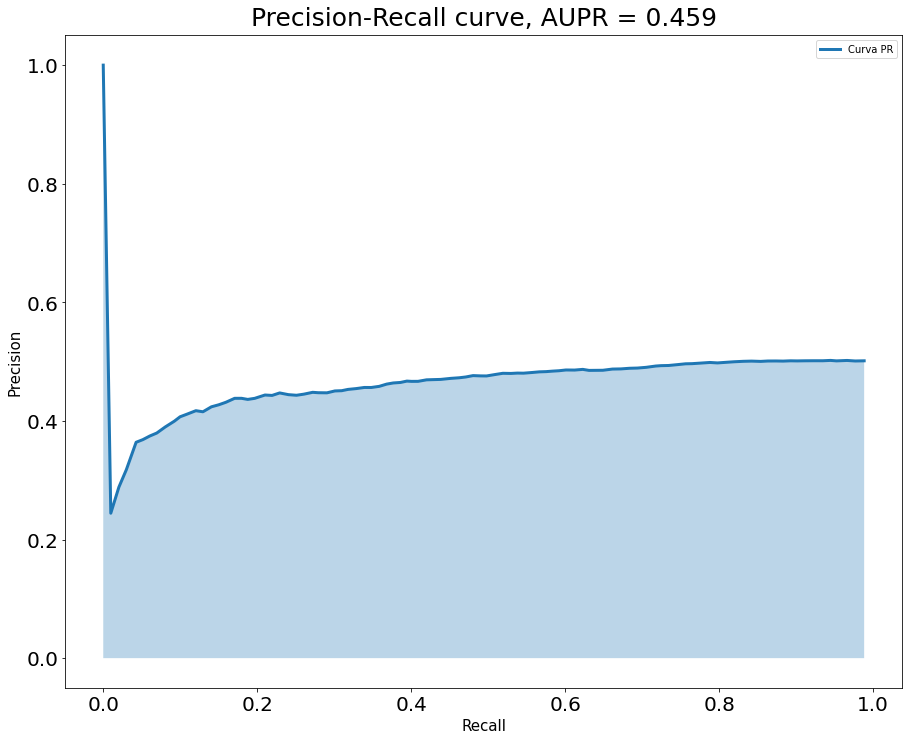

In [79]:
# Calculo del AUPR
aupr = np.trapz(array_Prec_Recall_x_threshold[:,0], array_Prec_Recall_x_threshold[:,1])

# Plot
plt.figure(figsize=(15,12))
plt.plot(array_Prec_Recall_x_threshold[:,1],array_Prec_Recall_x_threshold[:,0],label='Curva PR',lw=3)
#plt.plot(np.linspace(0,1,100),np.linspace(1,0.5,100),'k--',label='Curva ROC aleatoria')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.title('Precision-Recall curve, AUPR = %.3f'%aupr,fontsize=25,pad=10)
plt.fill_between(array_Prec_Recall_x_threshold[:,1],array_Prec_Recall_x_threshold[:,0],alpha=0.3)
plt.legend()
plt.savefig('/content/AUPR_Fashion_vs_MNIST')

## Ploting Test and OD images with heatmaps VS Clusters

In [ ]:
# Genera Heatmaps de GradCAM+  ()

contador             = 0
contador_comparacion = 0

# Definimos lo que queremos comparar
pos_inicio                          = 2500
pos_fin                             = 2550
predicciones                        = predicciones_test[pos_inicio:pos_fin]
array_htmaps_a_plotear              = array_htmaps_test_reesc[pos_inicio:pos_fin]
array_similaridad                   = array_ssim_x_imagen_test[pos_inicio:pos_fin]
imagenes                            = test_images[pos_inicio:pos_fin]

predicciones_comparacion            = predicciones_od[pos_inicio:pos_fin]
array_htmaps_a_plotear_comparacion  = array_htmaps_od_reesc[pos_inicio:pos_fin]
array_similaridad_comparacion       = array_ssim_x_imagen_od[pos_inicio:pos_fin]
imagenes_comparacion                = od_test_images[pos_inicio:pos_fin]

# Es una imagen estatica luego la leemos solo una vez
image_2 = io.imread('/content/Heatmaps_x_clase_y_cluster_{}.png'.format(modo_heatmaps))/255.0

# Barra de progreso
bar            = progressbar.ProgressBar(maxval=array_htmaps_a_plotear.shape[0],widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.SimpleProgress()])
bar.start()

while contador < len(predicciones):

  # En cada foto se genera una nueva figura
  fig, ax = plt.subplots(nrows=10, ncols=5, clear=True, figsize=[25,40])
  fig.suptitle('Fashion_MNIST vs MNIST',fontsize=32, y=0.92)
  # i vale 0 y 5
  for i in range(10): 
    
    for j in range(5):

      if i < 5:
        numero_clase = predicciones[contador]
        nombre_clase = class_names[numero_clase]
        gradcam_htmap = array_htmaps_a_plotear[contador]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad[contador,0],3))
        plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes[contador,:,:,0])
        ax[i,j].axis('off')

        contador = contador + 1 

      else:
        numero_clase = predicciones_comparacion[contador_comparacion]
        nombre_clase = class_names[numero_clase]
        gradcam_htmap = array_htmaps_a_plotear_comparacion[contador_comparacion]
        titulo = '{} // {}'.format(nombre_clase,round(array_similaridad_comparacion[contador_comparacion,0],3))
        plot_heatmap(ax,i,j,gradcam_htmap, title=titulo, superimposed_img = True,imagen=imagenes_comparacion[contador_comparacion,:,:,0])
        ax[i,j].axis('off')

        contador_comparacion = contador_comparacion + 1 

  # Para crear la escala de colores
  fig.subplots_adjust(right=0.90)
  cbar_ax = fig.add_axes([0.93, 0.35, 0.03, 0.4])
  fig.colorbar(ax[0,0].get_images()[1], cax=cbar_ax,)


  fig_name = './pelicula/fraim_'+ str(contador) + '.png'
  plt.savefig(fig_name)
  fig.clear()
  plt.close(fig) # Para no mostrar las figuras

  image_1 = io.imread(fig_name)/255.0
  

  '''
  fig, axs = plt.subplots(1,2,sharex=True,sharey=True,fÇigsize=(60,60),tight_layout=True,gridspec_kw={'width_ratios': [2, 1]})
  #fig.suptitle('Analisis estadístico del SSIM y MSE de cuando no hay deriva VS cuando hay', fontsize=35)
  axs[0].imshow(image_1,vmin=0,vmax=1)
  axs[1].imshow(image_2,vmin=0,vmax=1)
  
  '''
  fig = plt.figure(figsize=(80, 60)) 

  ax0 = plt.subplot(121)
  ax0.imshow(image_1,vmin=0,vmax=1)
  ax0.axis('off')

  ax1 = plt.subplot(122)
  ax1.imshow(image_2,vmin=0,vmax=1)
  ax1.axis('off')
  plt.subplots_adjust(wspace=-0.47)

  plt.savefig('/content/pelicula_completa/fraim_'+ str(contador) + '.png')
  fig.clear()
  plt.close(fig)
  bar.update(contador)
  

[====================================================================] 50 of 50

# Codigo de pruebas


Para Javi


In [ ]:
# Creacion de heatmaps clusters para javi
array_labels_de_cada_cluster  = array_labels_agg_x_clase
array_htmaps_x_clase_cluster = np.zeros((num_clases,))
modo_heatmaps                     = 'mediana'
for clase in range(num_clases):

  # Capturamos los valores unicos y cuantos de cada
  unique, counts = np.unique(array_labels_de_cada_cluster[clase], return_counts=True)

  # Eliminamos el indice -1 ya que no vamos a utilizar los outliers si los hay
  if -1 in unique:
    unique = np.delete(unique,0) # Unique contiene cuantos valores unicos hay en el array
    counts = np.delete(counts,0) # Counts contiene el numero de veces que se repite cada valor unico
  
  for i_unique,cluster in enumerate(unique):

    with open('/content/drive/MyDrive/Para_Javi/array_heatmaps_clase_{}_cluster_{}.npy'.format(clase,int(cluster)), 'wb') as f:
       
      np.save(f, calculo_htmaps_x_cluster_para_javi(array_labels_de_cada_cluster[clase],array_heatmaps_train_x_clase[clase]))


In [ ]:
def calculo_htmaps_x_cluster_para_javi(a_indice_clust, a_heatmaps,modo='mediana',cuantiles=[0,0.25,0.50,0.75,1]):
  '''
  Funcion que recibe:
  - Array con indices de cluster de una clase. Si indice es -1, no se usa ese htmap
  - Array con htmaps
  - Lista con los cuantiles (opcional)
  Devuelve:
  - Htmaps por cada cluster de cada clase. Lista de 10 arrays con cada array siendo (x,11,11), siendo X el nº de clusters
  - Si modo = 'cuantiles', entonces se devuelven los cuantiles de cada cluster -> lista de 10 arrays de la forma (x,y,11,11) x=nº clusters, y=nº cuantiles
  '''

  # Capturamos los indices de los heatmaps que pertenecen a ese cluster
  a_indices_un_cluster = np.asarray(np.asarray(a_indice_clust == cluster).nonzero()[0])

  # Creamos un array con los heatmaps correspondientes a esos indices (a ese cluster)
  a_aux_htmaps = np.zeros((len(a_indices_un_cluster),a_heatmaps.shape[1],a_heatmaps.shape[2]))
  for i,i_un_cluster in enumerate(a_indices_un_cluster):
    a_aux_htmaps[i] = a_heatmaps[int(i_un_cluster)]
    
  return a_aux_htmaps

In [ ]:
# Prueba que voy a hacer para comprobar como se guarda el h5
%cd /content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Datasets
model.save('Pruebah5.h5')

/content/drive/MyDrive/Colab_Notebooks/3_OOD_XAI/Datasets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


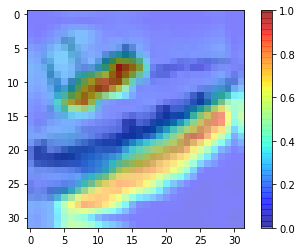

In [ ]:
pos = buscar_num(8,0,train_labels_shuffled,1)
plt.imshow(train_images_shuffled[pos].squeeze(),vmin=0,vmax=1)
plt.imshow(resize(array_heatmaps_train_x_clase[8,1],(32,32)),alpha=0.5,cmap='jet',vmin=0,vmax=1)
plt.colorbar()

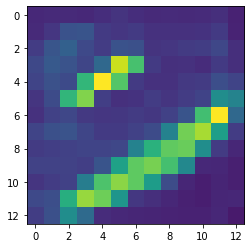

In [ ]:
plt.imshow(array_heatmaps_train_x_clase[8,1],vmin=0,vmax=1)

In [ ]:
batches = test_datagen.flow(test_images,test_labels,shuffle=False,batch_size=100)

In [ ]:
x_batch, y_batch = next(batches)

In [ ]:
x_batch[0]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


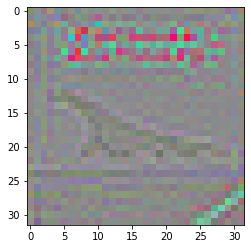

In [ ]:
num = 3
plt.imshow((x_batch[num]-x_batch[num].min())/(x_batch[num].max()-x_batch[num].min()),vmin=0,vmax=1)
print(y_batch[num])

In [ ]:

'''
#Creamos el modelo
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D

indices_0_9 = [545,5848,35,369,803,45,729,34,787,284] # Son los indices de los números (ordenados de 0 a 9)

!nvidia-smi
!/usr/local/cuda/bin/nvcc --version
'''

In [ ]:
model.summary()

In [ ]:
from tf_explain.core import GradCAM

In [ ]:
y_batch[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
img = x_batch[0]
prediccion = np.argmax(model.predict(np.expand_dims(x_batch[0],axis=0)))
data = ([img], None)

explainer = GradCAM()
grid = explainer.explain(data, model,class_index=prediccion) 

explainer.save(grid, ".", "grad_cam.png")

In [ ]:
htmap = tf.keras.preprocessing.image.load_img('grad_cam.png', target_size=(32, 32))

In [ ]:
tf.keras.preprocessing.image.img_to_array(htmap)

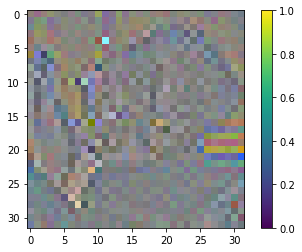

In [ ]:
im = (x_batch[0] - x_batch[0].min()) / (x_batch[0].max() - x_batch[0].min())
plt.imshow(im)
#plt.imshow(htmap,alpha=0.6,cmap='jet')
plt.colorbar()


In [ ]:
pip install tf-explain

     |████████████████████████████████| 51kB 6.4MB/s 


In [ ]:
batches = test_datagen.flow(test_images,test_labels,shuffle=False,batch_size=100)

In [ ]:
x_batch, y_batch = next(batches)

In [ ]:
pos = 85
htmap = grad_cam_plus(x_batch[pos],model,last_conv_layer,label_name=class_names)
htmap

airplane


<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.02346151, 0.2913969 ,
        0.19012512, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2848295 , 0.5044494 ,
        0.36826512, 0.        , 0.        ],
       [0.        , 0.        , 0.22496039, 0.48455703, 0.3748333 ,
        0.15374744, 0.        , 0.        ],
       [0.        , 0.11813726, 0.6800064 , 1.        , 0.6160714 ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5068885 , 0.90220207, 0.65907735,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]], dtype=float32)>

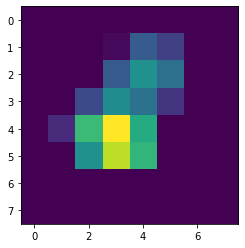

In [ ]:
plt.imshow(htmap,vmin=0,vmax=1)

dog


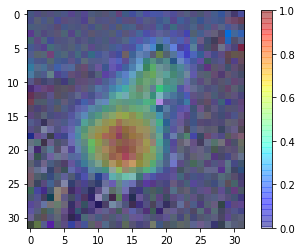

In [ ]:
im = (x_batch[pos] - x_batch[pos].min()) / (x_batch[pos].max() - x_batch[pos].min())
plt.imshow(im)
plt.imshow(resize(htmap,(32,32)),alpha=0.3,cmap='jet',vmin=0,vmax=1)
plt.colorbar()
print(class_names[np.argmax(y_batch[pos])])

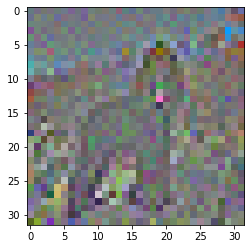

In [ ]:
im = (x_batch[pos] - x_batch[pos].min()) / (x_batch[pos].max() - x_batch[pos].min())
plt.imshow(im)

In [ ]:
pos = 85
htmap = grad_cam_plus(train_images[pos],model,last_conv_layer,label_name=class_names)
htmap

horse


<tf.Tensor: shape=(13, 13), dtype=float32, numpy=
array([[2.12490615e-02, 2.36936081e-02, 9.84172001e-02, 2.93629020e-01,
        2.52758503e-01, 0.00000000e+00, 2.37738952e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [5.92969507e-02, 0.00000000e+00, 2.71537825e-02, 3.93132985e-01,
        1.68624103e-01, 1.98734000e-01, 1.37673497e-01, 1.85046196e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [3.83822732e-02, 0.00000000e+00, 6.29518986e-01, 4.61501896e-01,
        1.98234543e-01, 5.15046656e-01, 5.82585692e-01, 3.75542045e-01,
        1.10807531e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.09766254e-01, 1.50724009e-01,
        4.99249995e-02, 4.91228938e-01, 7.51498580e-01, 2.04977900e-01,
        6.91288859e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0

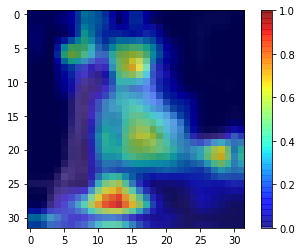

In [ ]:
plt.imshow(train_images[pos],vmin=0,vmax=1)
plt.imshow(resize(htmap,(32,32)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
plt.colorbar()

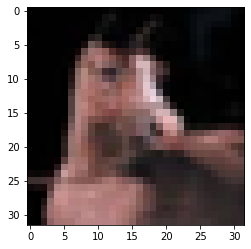

In [ ]:
plt.imshow(train_images[pos],vmin=0,vmax=1)

In [ ]:
plt.imshow(train_images[pos],vmin=0,vmax=1)
plt.imshow(resize(htmap,(32,32)),alpha=0.6,cmap='jet',vmin=0,vmax=1)
plt.colorbar()